In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

297


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:47<00:00,  1.26it/s]


In [12]:
Dataset = 'Small Village Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 6.60880708694458 [s] ... size 1445.218304 MB


In [14]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 43.92833399772644 [s] ... size 1926.957056 MB


In [15]:
del images_left_bgr,images_right_bgr

In [16]:
from timeit import default_timer as timer

In [17]:
time_all = []

In [18]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [19]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:00<00:00,  1.01s/it]


In [20]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 94377.74it/s]


In [21]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [22]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [23]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [24]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [25]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [26]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

MSER + SIFT

In [27]:
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [11:48<00:00, 11.81s/it]


In [28]:
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 357977.58it/s]


In [29]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [30]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [31]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [32]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [33]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [34]:
del Fdb, all_feat_mser_left, all_feat_mser_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [37]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [38]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [39]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [35]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:24<00:00,  2.46it/s]


In [36]:
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 13273.11it/s]


In [37]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [38]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [39]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [40]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [41]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [42]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [43]:
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:16<00:00,  2.27s/it]


In [44]:
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 74653.88it/s]


In [45]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [46]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [47]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [48]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [49]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [50]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SIFT

In [51]:
print(len(left_files_path))

61


In [52]:
print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
# del f

In [53]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:50<00:00,  3.84s/it]


In [54]:
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 77768.31it/s]


In [55]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [56]:
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [57]:
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [58]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [59]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [60]:
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [61]:
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:44<00:00,  3.74s/it]


In [62]:
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 36927.11it/s]


In [63]:
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [64]:
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [65]:
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [66]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [67]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [68]:
del Fdb, all_feat_surf_left, all_feat_surf_right

Total Matches,Robust Matches and Homography Computation

In [69]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [70]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [71]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [72]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [73]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [74]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [75]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:44,  3.75s/it]


Number of matches 34199
Number of matches After Lowe's Ratio 507
Number of Robust matches 177




  3%|▎         | 2/61 [00:08<03:59,  4.06s/it]


Number of matches 35002
Number of matches After Lowe's Ratio 716
Number of Robust matches 251




  5%|▍         | 3/61 [00:12<03:51,  3.99s/it]


Number of matches 30176
Number of matches After Lowe's Ratio 550
Number of Robust matches 179




  7%|▋         | 4/61 [00:15<03:35,  3.79s/it]


Number of matches 30093
Number of matches After Lowe's Ratio 678
Number of Robust matches 390




  8%|▊         | 5/61 [00:19<03:32,  3.79s/it]


Number of matches 32458
Number of matches After Lowe's Ratio 440
Number of Robust matches 227




 10%|▉         | 6/61 [00:23<03:33,  3.88s/it]


Number of matches 40164
Number of matches After Lowe's Ratio 1540
Number of Robust matches 1154




 11%|█▏        | 7/61 [00:28<03:51,  4.29s/it]


Number of matches 37252
Number of matches After Lowe's Ratio 1589
Number of Robust matches 1135




 13%|█▎        | 8/61 [00:33<04:00,  4.53s/it]


Number of matches 29747
Number of matches After Lowe's Ratio 964
Number of Robust matches 627




 15%|█▍        | 9/61 [00:37<03:42,  4.28s/it]


Number of matches 30558
Number of matches After Lowe's Ratio 764
Number of Robust matches 469




 16%|█▋        | 10/61 [00:41<03:31,  4.15s/it]


Number of matches 32053
Number of matches After Lowe's Ratio 677
Number of Robust matches 311




 18%|█▊        | 11/61 [00:46<03:33,  4.28s/it]


Number of matches 32381
Number of matches After Lowe's Ratio 579
Number of Robust matches 163




 20%|█▉        | 12/61 [00:50<03:25,  4.20s/it]


Number of matches 32496
Number of matches After Lowe's Ratio 596
Number of Robust matches 143




 21%|██▏       | 13/61 [00:58<04:27,  5.57s/it]


Number of matches 54658
Number of matches After Lowe's Ratio 257
Number of Robust matches 72




 23%|██▎       | 14/61 [01:11<06:08,  7.84s/it]


Number of matches 86841
Number of matches After Lowe's Ratio 216
Number of Robust matches 124




 25%|██▍       | 15/61 [01:21<06:25,  8.39s/it]


Number of matches 45969
Number of matches After Lowe's Ratio 411
Number of Robust matches 235




 26%|██▌       | 16/61 [01:27<05:48,  7.74s/it]


Number of matches 33352
Number of matches After Lowe's Ratio 753
Number of Robust matches 247




 28%|██▊       | 17/61 [01:32<04:56,  6.74s/it]


Number of matches 32253
Number of matches After Lowe's Ratio 643
Number of Robust matches 198




 30%|██▉       | 18/61 [01:36<04:17,  5.98s/it]


Number of matches 36758
Number of matches After Lowe's Ratio 544
Number of Robust matches 148




 31%|███       | 19/61 [01:41<03:56,  5.63s/it]


Number of matches 32492
Number of matches After Lowe's Ratio 411
Number of Robust matches 147




 33%|███▎      | 20/61 [01:45<03:33,  5.22s/it]


Number of matches 36392
Number of matches After Lowe's Ratio 315
Number of Robust matches 134




 34%|███▍      | 21/61 [01:50<03:22,  5.06s/it]


Number of matches 42773
Number of matches After Lowe's Ratio 956
Number of Robust matches 700




 36%|███▌      | 22/61 [01:57<03:48,  5.87s/it]


Number of matches 53307
Number of matches After Lowe's Ratio 1761
Number of Robust matches 1202




 38%|███▊      | 23/61 [02:05<04:00,  6.34s/it]


Number of matches 38624
Number of matches After Lowe's Ratio 1096
Number of Robust matches 776




 39%|███▉      | 24/61 [02:11<03:48,  6.19s/it]


Number of matches 27994
Number of matches After Lowe's Ratio 286
Number of Robust matches 131




 41%|████      | 25/61 [02:14<03:08,  5.25s/it]


Number of matches 27814
Number of matches After Lowe's Ratio 326
Number of Robust matches 121




 43%|████▎     | 26/61 [02:17<02:43,  4.68s/it]


Number of matches 34801
Number of matches After Lowe's Ratio 211
Number of Robust matches 55




 44%|████▍     | 27/61 [02:22<02:38,  4.67s/it]


Number of matches 34671
Number of matches After Lowe's Ratio 498
Number of Robust matches 136




 46%|████▌     | 28/61 [02:27<02:37,  4.76s/it]


Number of matches 44043
Number of matches After Lowe's Ratio 289
Number of Robust matches 102




 48%|████▊     | 29/61 [02:35<03:07,  5.84s/it]


Number of matches 65763
Number of matches After Lowe's Ratio 189
Number of Robust matches 77




 49%|████▉     | 30/61 [02:45<03:35,  6.95s/it]


Number of matches 51581
Number of matches After Lowe's Ratio 280
Number of Robust matches 126




 51%|█████     | 31/61 [02:52<03:32,  7.07s/it]


Number of matches 34879
Number of matches After Lowe's Ratio 343
Number of Robust matches 94




 52%|█████▏    | 32/61 [02:56<02:56,  6.08s/it]


Number of matches 24551
Number of matches After Lowe's Ratio 494
Number of Robust matches 135




 54%|█████▍    | 33/61 [02:58<02:21,  5.04s/it]


Number of matches 26311
Number of matches After Lowe's Ratio 482
Number of Robust matches 141




 56%|█████▌    | 34/61 [03:02<02:02,  4.54s/it]


Number of matches 27904
Number of matches After Lowe's Ratio 377
Number of Robust matches 131




 57%|█████▋    | 35/61 [03:05<01:47,  4.15s/it]


Number of matches 32478
Number of matches After Lowe's Ratio 415
Number of Robust matches 173




 59%|█████▉    | 36/61 [03:10<01:52,  4.49s/it]


Number of matches 43545
Number of matches After Lowe's Ratio 729
Number of Robust matches 482




 61%|██████    | 37/61 [03:18<02:08,  5.36s/it]


Number of matches 54459
Number of matches After Lowe's Ratio 1166
Number of Robust matches 820




 62%|██████▏   | 38/61 [03:26<02:20,  6.11s/it]


Number of matches 37887
Number of matches After Lowe's Ratio 1115
Number of Robust matches 795




 64%|██████▍   | 39/61 [03:30<02:02,  5.55s/it]


Number of matches 27016
Number of matches After Lowe's Ratio 621
Number of Robust matches 446




 66%|██████▌   | 40/61 [03:32<01:36,  4.61s/it]


Number of matches 15395
Number of matches After Lowe's Ratio 251
Number of Robust matches 136




 67%|██████▋   | 41/61 [03:33<01:12,  3.61s/it]


Number of matches 18483
Number of matches After Lowe's Ratio 294
Number of Robust matches 110




 69%|██████▉   | 42/61 [03:35<00:59,  3.11s/it]


Number of matches 25066
Number of matches After Lowe's Ratio 447
Number of Robust matches 133




 70%|███████   | 43/61 [03:39<00:58,  3.25s/it]


Number of matches 39986
Number of matches After Lowe's Ratio 363
Number of Robust matches 95




 72%|███████▏  | 44/61 [03:46<01:16,  4.51s/it]


Number of matches 61834
Number of matches After Lowe's Ratio 169
Number of Robust matches 79




 74%|███████▍  | 45/61 [04:01<01:58,  7.42s/it]


Number of matches 95237
Number of matches After Lowe's Ratio 219
Number of Robust matches 144




 75%|███████▌  | 46/61 [04:13<02:12,  8.81s/it]


Number of matches 60829
Number of matches After Lowe's Ratio 185
Number of Robust matches 110




 77%|███████▋  | 47/61 [04:21<02:01,  8.70s/it]


Number of matches 37081
Number of matches After Lowe's Ratio 203
Number of Robust matches 112




 79%|███████▊  | 48/61 [04:25<01:35,  7.33s/it]


Number of matches 27312
Number of matches After Lowe's Ratio 318
Number of Robust matches 108




 80%|████████  | 49/61 [04:28<01:10,  5.90s/it]


Number of matches 15737
Number of matches After Lowe's Ratio 341
Number of Robust matches 85




 82%|████████▏ | 50/61 [04:29<00:50,  4.55s/it]


Number of matches 24741
Number of matches After Lowe's Ratio 313
Number of Robust matches 118




 84%|████████▎ | 51/61 [04:33<00:41,  4.20s/it]


Number of matches 32474
Number of matches After Lowe's Ratio 477
Number of Robust matches 323




 85%|████████▌ | 52/61 [04:38<00:39,  4.41s/it]


Number of matches 46462
Number of matches After Lowe's Ratio 856
Number of Robust matches 671




 87%|████████▋ | 53/61 [04:46<00:44,  5.56s/it]


Number of matches 57608
Number of matches After Lowe's Ratio 1250
Number of Robust matches 859




 89%|████████▊ | 54/61 [04:55<00:46,  6.61s/it]


Number of matches 56279
Number of matches After Lowe's Ratio 1222
Number of Robust matches 885




 90%|█████████ | 55/61 [05:03<00:42,  7.07s/it]


Number of matches 39926
Number of matches After Lowe's Ratio 685
Number of Robust matches 461




 92%|█████████▏| 56/61 [05:08<00:31,  6.33s/it]


Number of matches 30586
Number of matches After Lowe's Ratio 319
Number of Robust matches 226




 93%|█████████▎| 57/61 [05:11<00:21,  5.36s/it]


Number of matches 25532
Number of matches After Lowe's Ratio 242
Number of Robust matches 107




 95%|█████████▌| 58/61 [05:14<00:13,  4.64s/it]


Number of matches 21565
Number of matches After Lowe's Ratio 231
Number of Robust matches 83




 97%|█████████▋| 59/61 [05:17<00:08,  4.12s/it]


Number of matches 47461
Number of matches After Lowe's Ratio 249
Number of Robust matches 98




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 69453
Number of matches After Lowe's Ratio 212
Number of Robust matches 124




  2%|▏         | 1/60 [00:04<04:15,  4.33s/it]


Number of matches 43080
Number of matches After Lowe's Ratio 466
Number of Robust matches 140




  3%|▎         | 2/60 [00:12<05:20,  5.52s/it]


Number of matches 60518
Number of matches After Lowe's Ratio 452
Number of Robust matches 179




  5%|▌         | 3/60 [00:21<06:04,  6.40s/it]


Number of matches 40645
Number of matches After Lowe's Ratio 161
Number of Robust matches 60




  7%|▋         | 4/60 [00:26<05:44,  6.15s/it]


Number of matches 34816
Number of matches After Lowe's Ratio 298
Number of Robust matches 122




  8%|▊         | 5/60 [00:31<05:12,  5.68s/it]


Number of matches 33906
Number of matches After Lowe's Ratio 609
Number of Robust matches 237




 10%|█         | 6/60 [00:35<04:48,  5.34s/it]


Number of matches 34306
Number of matches After Lowe's Ratio 553
Number of Robust matches 227




 12%|█▏        | 7/60 [00:39<04:21,  4.93s/it]


Number of matches 30653
Number of matches After Lowe's Ratio 769
Number of Robust matches 311




 13%|█▎        | 8/60 [00:42<03:49,  4.42s/it]


Number of matches 26414
Number of matches After Lowe's Ratio 788
Number of Robust matches 437




 15%|█▌        | 9/60 [00:45<03:20,  3.94s/it]


Number of matches 22910
Number of matches After Lowe's Ratio 818
Number of Robust matches 394




 17%|█▋        | 10/60 [00:48<02:59,  3.59s/it]


Number of matches 22843
Number of matches After Lowe's Ratio 1091
Number of Robust matches 823




 18%|█▊        | 11/60 [00:50<02:38,  3.22s/it]


Number of matches 23216
Number of matches After Lowe's Ratio 1035
Number of Robust matches 707




 20%|██        | 12/60 [00:53<02:25,  3.04s/it]


Number of matches 30508
Number of matches After Lowe's Ratio 803
Number of Robust matches 564




 22%|██▏       | 13/60 [00:57<02:36,  3.33s/it]


Number of matches 33067
Number of matches After Lowe's Ratio 890
Number of Robust matches 480




 23%|██▎       | 14/60 [01:01<02:43,  3.55s/it]


Number of matches 34821
Number of matches After Lowe's Ratio 852
Number of Robust matches 354




 25%|██▌       | 15/60 [01:06<02:53,  3.85s/it]


Number of matches 33892
Number of matches After Lowe's Ratio 542
Number of Robust matches 215




 27%|██▋       | 16/60 [01:10<02:56,  4.00s/it]


Number of matches 27929
Number of matches After Lowe's Ratio 553
Number of Robust matches 234




 28%|██▊       | 17/60 [01:13<02:42,  3.79s/it]


Number of matches 33854
Number of matches After Lowe's Ratio 442
Number of Robust matches 191




 30%|███       | 18/60 [01:18<02:47,  4.00s/it]


Number of matches 41142
Number of matches After Lowe's Ratio 520
Number of Robust matches 182




 32%|███▏      | 19/60 [01:24<03:05,  4.53s/it]


Number of matches 33056
Number of matches After Lowe's Ratio 232
Number of Robust matches 97




 33%|███▎      | 20/60 [01:27<02:51,  4.28s/it]


Number of matches 27945
Number of matches After Lowe's Ratio 346
Number of Robust matches 141




 35%|███▌      | 21/60 [01:31<02:38,  4.06s/it]


Number of matches 39280
Number of matches After Lowe's Ratio 611
Number of Robust matches 278




 37%|███▋      | 22/60 [01:36<02:50,  4.48s/it]


Number of matches 35020
Number of matches After Lowe's Ratio 675
Number of Robust matches 320




 38%|███▊      | 23/60 [01:40<02:40,  4.35s/it]


Number of matches 30181
Number of matches After Lowe's Ratio 676
Number of Robust matches 260




 40%|████      | 24/60 [01:44<02:25,  4.04s/it]


Number of matches 27761
Number of matches After Lowe's Ratio 973
Number of Robust matches 485




 42%|████▏     | 25/60 [01:47<02:13,  3.80s/it]


Number of matches 20441
Number of matches After Lowe's Ratio 1258
Number of Robust matches 967




 43%|████▎     | 26/60 [01:49<01:47,  3.17s/it]


Number of matches 9484
Number of matches After Lowe's Ratio 736
Number of Robust matches 600




 45%|████▌     | 27/60 [01:49<01:21,  2.46s/it]


Number of matches 15669
Number of matches After Lowe's Ratio 531
Number of Robust matches 414




 47%|████▋     | 28/60 [01:51<01:11,  2.24s/it]


Number of matches 34109
Number of matches After Lowe's Ratio 888
Number of Robust matches 508




 48%|████▊     | 29/60 [01:57<01:40,  3.24s/it]


Number of matches 40934
Number of matches After Lowe's Ratio 1176
Number of Robust matches 640




 50%|█████     | 30/60 [02:02<01:56,  3.89s/it]


Number of matches 39357
Number of matches After Lowe's Ratio 868
Number of Robust matches 292




 52%|█████▏    | 31/60 [02:08<02:11,  4.53s/it]


Number of matches 38655
Number of matches After Lowe's Ratio 745
Number of Robust matches 271




 53%|█████▎    | 32/60 [02:13<02:07,  4.56s/it]


Number of matches 29950
Number of matches After Lowe's Ratio 575
Number of Robust matches 302




 55%|█████▌    | 33/60 [02:16<01:51,  4.14s/it]


Number of matches 25428
Number of matches After Lowe's Ratio 464
Number of Robust matches 291




 57%|█████▋    | 34/60 [02:20<01:45,  4.06s/it]


Number of matches 47461
Number of matches After Lowe's Ratio 405
Number of Robust matches 229




 58%|█████▊    | 35/60 [02:27<02:03,  4.94s/it]


Number of matches 38123
Number of matches After Lowe's Ratio 332
Number of Robust matches 167




 60%|██████    | 36/60 [02:32<01:57,  4.88s/it]


Number of matches 31812
Number of matches After Lowe's Ratio 298
Number of Robust matches 136




 62%|██████▏   | 37/60 [02:36<01:49,  4.76s/it]


Number of matches 37496
Number of matches After Lowe's Ratio 623
Number of Robust matches 272




 63%|██████▎   | 38/60 [02:41<01:48,  4.94s/it]


Number of matches 40383
Number of matches After Lowe's Ratio 625
Number of Robust matches 228




 65%|██████▌   | 39/60 [02:47<01:49,  5.22s/it]


Number of matches 36317
Number of matches After Lowe's Ratio 847
Number of Robust matches 296




 67%|██████▋   | 40/60 [02:52<01:40,  5.05s/it]


Number of matches 35360
Number of matches After Lowe's Ratio 1400
Number of Robust matches 922




 68%|██████▊   | 41/60 [02:56<01:28,  4.68s/it]


Number of matches 24648
Number of matches After Lowe's Ratio 1220
Number of Robust matches 915




 70%|███████   | 42/60 [02:57<01:08,  3.79s/it]


Number of matches 959
Number of matches After Lowe's Ratio 48
Number of Robust matches 33




 72%|███████▏  | 43/60 [02:58<00:49,  2.89s/it]


Number of matches 20233
Number of matches After Lowe's Ratio 106
Number of Robust matches 70




 73%|███████▎  | 44/60 [03:01<00:44,  2.77s/it]


Number of matches 36008
Number of matches After Lowe's Ratio 860
Number of Robust matches 774




 75%|███████▌  | 45/60 [03:05<00:50,  3.38s/it]


Number of matches 42174
Number of matches After Lowe's Ratio 1230
Number of Robust matches 861




 77%|███████▋  | 46/60 [03:12<00:59,  4.28s/it]


Number of matches 37208
Number of matches After Lowe's Ratio 673
Number of Robust matches 303




 78%|███████▊  | 47/60 [03:16<00:56,  4.36s/it]


Number of matches 33717
Number of matches After Lowe's Ratio 626
Number of Robust matches 192




 80%|████████  | 48/60 [03:20<00:50,  4.23s/it]


Number of matches 31670
Number of matches After Lowe's Ratio 452
Number of Robust matches 193




 82%|████████▏ | 49/60 [03:24<00:44,  4.07s/it]


Number of matches 22741
Number of matches After Lowe's Ratio 389
Number of Robust matches 224




 83%|████████▎ | 50/60 [03:27<00:36,  3.69s/it]


Number of matches 39097
Number of matches After Lowe's Ratio 486
Number of Robust matches 240




 85%|████████▌ | 51/60 [03:31<00:34,  3.84s/it]


Number of matches 21927
Number of matches After Lowe's Ratio 278
Number of Robust matches 137




 87%|████████▋ | 52/60 [03:34<00:28,  3.61s/it]


Number of matches 34268
Number of matches After Lowe's Ratio 191
Number of Robust matches 75




 88%|████████▊ | 53/60 [03:39<00:27,  3.88s/it]


Number of matches 35120
Number of matches After Lowe's Ratio 466
Number of Robust matches 170




 90%|█████████ | 54/60 [03:44<00:25,  4.19s/it]


Number of matches 36437
Number of matches After Lowe's Ratio 595
Number of Robust matches 199




 92%|█████████▏| 55/60 [03:48<00:21,  4.24s/it]


Number of matches 34276
Number of matches After Lowe's Ratio 629
Number of Robust matches 235




 93%|█████████▎| 56/60 [03:52<00:16,  4.19s/it]


Number of matches 31206
Number of matches After Lowe's Ratio 1194
Number of Robust matches 806




 95%|█████████▌| 57/60 [03:55<00:11,  3.90s/it]


Number of matches 23731
Number of matches After Lowe's Ratio 1312
Number of Robust matches 1209




 97%|█████████▋| 58/60 [03:58<00:06,  3.47s/it]


Number of matches 9809
Number of matches After Lowe's Ratio 975
Number of Robust matches 911




 98%|█████████▊| 59/60 [03:58<00:02,  2.67s/it]


Number of matches 17434
Number of matches After Lowe's Ratio 864
Number of Robust matches 725




In [76]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.04502677917480469 [s] ... size 0.006368 MB


In [77]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0031905174255371094 [s] ... size 0.006296 MB


In [78]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [79]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [80]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [81]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:14<14:04, 14.07s/it]


Number of matches 29526
Number of matches After Lowe's Ratio 2594
Number of Robust matches 1038




  3%|▎         | 2/61 [00:27<13:39, 13.88s/it]


Number of matches 26628
Number of matches After Lowe's Ratio 2609
Number of Robust matches 946




  5%|▍         | 3/61 [00:32<10:55, 11.30s/it]


Number of matches 26356
Number of matches After Lowe's Ratio 2211
Number of Robust matches 775




  7%|▋         | 4/61 [00:38<09:01,  9.51s/it]


Number of matches 29884
Number of matches After Lowe's Ratio 2537
Number of Robust matches 1502




  8%|▊         | 5/61 [00:45<08:15,  8.84s/it]


Number of matches 44094
Number of matches After Lowe's Ratio 2345
Number of Robust matches 1345




 10%|▉         | 6/61 [00:56<08:44,  9.53s/it]


Number of matches 44100
Number of matches After Lowe's Ratio 8773
Number of Robust matches 7608




 11%|█▏        | 7/61 [01:07<08:53,  9.89s/it]


Number of matches 38884
Number of matches After Lowe's Ratio 8394
Number of Robust matches 6770




 13%|█▎        | 8/61 [01:15<08:18,  9.41s/it]


Number of matches 29764
Number of matches After Lowe's Ratio 4418
Number of Robust matches 3305




 15%|█▍        | 9/61 [01:21<07:21,  8.49s/it]


Number of matches 26720
Number of matches After Lowe's Ratio 2683
Number of Robust matches 1666




 16%|█▋        | 10/61 [01:27<06:25,  7.56s/it]


Number of matches 29551
Number of matches After Lowe's Ratio 2456
Number of Robust matches 1008




 18%|█▊        | 11/61 [01:33<05:55,  7.10s/it]


Number of matches 31699
Number of matches After Lowe's Ratio 2639
Number of Robust matches 928




 20%|█▉        | 12/61 [01:40<05:50,  7.15s/it]


Number of matches 35577
Number of matches After Lowe's Ratio 3299
Number of Robust matches 985




 21%|██▏       | 13/61 [01:49<06:03,  7.57s/it]


Number of matches 44381
Number of matches After Lowe's Ratio 1704
Number of Robust matches 522




 23%|██▎       | 14/61 [02:02<07:18,  9.33s/it]


Number of matches 55562
Number of matches After Lowe's Ratio 1872
Number of Robust matches 1171




 25%|██▍       | 15/61 [02:16<08:17, 10.83s/it]


Number of matches 46637
Number of matches After Lowe's Ratio 2700
Number of Robust matches 1620




 26%|██▌       | 16/61 [02:28<08:12, 10.95s/it]


Number of matches 37278
Number of matches After Lowe's Ratio 4433
Number of Robust matches 1804




 28%|██▊       | 17/61 [02:36<07:22, 10.06s/it]


Number of matches 31944
Number of matches After Lowe's Ratio 3461
Number of Robust matches 1353




 30%|██▉       | 18/61 [02:42<06:27,  9.01s/it]


Number of matches 29639
Number of matches After Lowe's Ratio 2301
Number of Robust matches 739




 31%|███       | 19/61 [02:48<05:43,  8.19s/it]


Number of matches 27400
Number of matches After Lowe's Ratio 1883
Number of Robust matches 688




 33%|███▎      | 20/61 [02:54<05:03,  7.41s/it]


Number of matches 34720
Number of matches After Lowe's Ratio 1556
Number of Robust matches 723




 34%|███▍      | 21/61 [03:03<05:15,  7.90s/it]


Number of matches 40195
Number of matches After Lowe's Ratio 4281
Number of Robust matches 3317




 36%|███▌      | 22/61 [03:17<06:16,  9.65s/it]


Number of matches 40871
Number of matches After Lowe's Ratio 6655
Number of Robust matches 5654




 38%|███▊      | 23/61 [03:27<06:07,  9.68s/it]


Number of matches 34001
Number of matches After Lowe's Ratio 4885
Number of Robust matches 4466




 39%|███▉      | 24/61 [03:33<05:25,  8.80s/it]


Number of matches 26288
Number of matches After Lowe's Ratio 2065
Number of Robust matches 949




 41%|████      | 25/61 [03:38<04:37,  7.70s/it]


Number of matches 27440
Number of matches After Lowe's Ratio 1726
Number of Robust matches 754




 43%|████▎     | 26/61 [03:44<04:10,  7.16s/it]


Number of matches 29435
Number of matches After Lowe's Ratio 1228
Number of Robust matches 399




 44%|████▍     | 27/61 [03:52<04:05,  7.21s/it]


Number of matches 35401
Number of matches After Lowe's Ratio 2724
Number of Robust matches 884




 46%|████▌     | 28/61 [04:05<04:53,  8.90s/it]


Number of matches 47665
Number of matches After Lowe's Ratio 2257
Number of Robust matches 767




 48%|████▊     | 29/61 [04:22<06:07, 11.47s/it]


Number of matches 61201
Number of matches After Lowe's Ratio 1706
Number of Robust matches 693




 49%|████▉     | 30/61 [04:41<07:09, 13.85s/it]


Number of matches 40780
Number of matches After Lowe's Ratio 2110
Number of Robust matches 1133




 51%|█████     | 31/61 [04:51<06:14, 12.50s/it]


Number of matches 35221
Number of matches After Lowe's Ratio 2422
Number of Robust matches 851




 52%|█████▏    | 32/61 [04:58<05:19, 11.00s/it]


Number of matches 31090
Number of matches After Lowe's Ratio 3090
Number of Robust matches 958




 54%|█████▍    | 33/61 [05:05<04:30,  9.66s/it]


Number of matches 27466
Number of matches After Lowe's Ratio 2355
Number of Robust matches 762




 56%|█████▌    | 34/61 [05:10<03:46,  8.40s/it]


Number of matches 27694
Number of matches After Lowe's Ratio 2168
Number of Robust matches 884




 57%|█████▋    | 35/61 [05:17<03:28,  8.01s/it]


Number of matches 30835
Number of matches After Lowe's Ratio 2175
Number of Robust matches 1002




 59%|█████▉    | 36/61 [05:26<03:24,  8.19s/it]


Number of matches 43447
Number of matches After Lowe's Ratio 3373
Number of Robust matches 2569




 61%|██████    | 37/61 [05:39<03:52,  9.69s/it]


Number of matches 44085
Number of matches After Lowe's Ratio 5906
Number of Robust matches 3863




 62%|██████▏   | 38/61 [05:53<04:11, 10.93s/it]


Number of matches 44435
Number of matches After Lowe's Ratio 6295
Number of Robust matches 4891




 64%|██████▍   | 39/61 [06:05<04:07, 11.27s/it]


Number of matches 36542
Number of matches After Lowe's Ratio 4393
Number of Robust matches 3190




 66%|██████▌   | 40/61 [06:13<03:35, 10.28s/it]


Number of matches 28727
Number of matches After Lowe's Ratio 2468
Number of Robust matches 1647




 67%|██████▋   | 41/61 [06:19<02:59,  8.97s/it]


Number of matches 27476
Number of matches After Lowe's Ratio 2220
Number of Robust matches 954




 69%|██████▉   | 42/61 [06:25<02:31,  7.98s/it]


Number of matches 28505
Number of matches After Lowe's Ratio 2477
Number of Robust matches 604




 70%|███████   | 43/61 [06:33<02:23,  8.00s/it]


Number of matches 37372
Number of matches After Lowe's Ratio 2143
Number of Robust matches 555




 72%|███████▏  | 44/61 [06:46<02:45,  9.73s/it]


Number of matches 59323
Number of matches After Lowe's Ratio 1209
Number of Robust matches 587




 74%|███████▍  | 45/61 [07:03<03:10, 11.89s/it]


Number of matches 61823
Number of matches After Lowe's Ratio 1531
Number of Robust matches 871




 75%|███████▌  | 46/61 [07:23<03:34, 14.31s/it]


Number of matches 52786
Number of matches After Lowe's Ratio 1221
Number of Robust matches 636




 77%|███████▋  | 47/61 [07:36<03:15, 13.95s/it]


Number of matches 37747
Number of matches After Lowe's Ratio 1497
Number of Robust matches 878




 79%|███████▊  | 48/61 [07:45<02:39, 12.28s/it]


Number of matches 32260
Number of matches After Lowe's Ratio 2608
Number of Robust matches 1060




 80%|████████  | 49/61 [07:52<02:09, 10.79s/it]


Number of matches 31260
Number of matches After Lowe's Ratio 2547
Number of Robust matches 855




 82%|████████▏ | 50/61 [07:59<01:45,  9.55s/it]


Number of matches 28785
Number of matches After Lowe's Ratio 2168
Number of Robust matches 1287




 84%|████████▎ | 51/61 [08:06<01:29,  8.99s/it]


Number of matches 38218
Number of matches After Lowe's Ratio 2978
Number of Robust matches 2366




 85%|████████▌ | 52/61 [08:20<01:33, 10.40s/it]


Number of matches 44569
Number of matches After Lowe's Ratio 4489
Number of Robust matches 3662




 87%|████████▋ | 53/61 [08:33<01:29, 11.17s/it]


Number of matches 43754
Number of matches After Lowe's Ratio 6531
Number of Robust matches 5442




 89%|████████▊ | 54/61 [08:46<01:21, 11.62s/it]


Number of matches 37223
Number of matches After Lowe's Ratio 6432
Number of Robust matches 4969




 90%|█████████ | 55/61 [08:54<01:03, 10.60s/it]


Number of matches 33040
Number of matches After Lowe's Ratio 5045
Number of Robust matches 3916




 92%|█████████▏| 56/61 [09:02<00:48,  9.71s/it]


Number of matches 30137
Number of matches After Lowe's Ratio 2905
Number of Robust matches 2393




 93%|█████████▎| 57/61 [09:09<00:35,  8.93s/it]


Number of matches 35839
Number of matches After Lowe's Ratio 2285
Number of Robust matches 1252




 95%|█████████▌| 58/61 [09:18<00:27,  9.06s/it]


Number of matches 42161
Number of matches After Lowe's Ratio 2376
Number of Robust matches 997




 97%|█████████▋| 59/61 [09:32<00:21, 10.51s/it]


Number of matches 41341
Number of matches After Lowe's Ratio 2240
Number of Robust matches 1034




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 56174
Number of matches After Lowe's Ratio 1863
Number of Robust matches 1122




  2%|▏         | 1/60 [00:09<09:05,  9.25s/it]


Number of matches 38696
Number of matches After Lowe's Ratio 3217
Number of Robust matches 1217




  3%|▎         | 2/60 [00:21<09:42, 10.04s/it]


Number of matches 49567
Number of matches After Lowe's Ratio 2819
Number of Robust matches 1093




  5%|▌         | 3/60 [00:34<10:35, 11.14s/it]


Number of matches 46179
Number of matches After Lowe's Ratio 2080
Number of Robust matches 711




  7%|▋         | 4/60 [00:46<10:35, 11.35s/it]


Number of matches 33471
Number of matches After Lowe's Ratio 2311
Number of Robust matches 946




  8%|▊         | 5/60 [00:54<09:28, 10.34s/it]


Number of matches 28528
Number of matches After Lowe's Ratio 2696
Number of Robust matches 979




 10%|█         | 6/60 [01:00<08:00,  8.89s/it]


Number of matches 27347
Number of matches After Lowe's Ratio 2337
Number of Robust matches 1071




 12%|█▏        | 7/60 [01:05<06:56,  7.85s/it]


Number of matches 27790
Number of matches After Lowe's Ratio 2547
Number of Robust matches 1124




 13%|█▎        | 8/60 [01:13<06:41,  7.72s/it]


Number of matches 30046
Number of matches After Lowe's Ratio 2892
Number of Robust matches 1776




 15%|█▌        | 9/60 [01:20<06:36,  7.77s/it]


Number of matches 37125
Number of matches After Lowe's Ratio 4234
Number of Robust matches 2765




 17%|█▋        | 10/60 [01:31<07:14,  8.70s/it]


Number of matches 37568
Number of matches After Lowe's Ratio 6722
Number of Robust matches 5765




 18%|█▊        | 11/60 [01:41<07:23,  9.05s/it]


Number of matches 33217
Number of matches After Lowe's Ratio 6899
Number of Robust matches 5535




 20%|██        | 12/60 [01:50<07:10,  8.97s/it]


Number of matches 30538
Number of matches After Lowe's Ratio 4049
Number of Robust matches 2842




 22%|██▏       | 13/60 [01:57<06:40,  8.51s/it]


Number of matches 30165
Number of matches After Lowe's Ratio 3283
Number of Robust matches 2015




 23%|██▎       | 14/60 [02:05<06:15,  8.17s/it]


Number of matches 29501
Number of matches After Lowe's Ratio 2878
Number of Robust matches 1169




 25%|██▌       | 15/60 [02:13<06:04,  8.10s/it]


Number of matches 31863
Number of matches After Lowe's Ratio 2214
Number of Robust matches 960




 27%|██▋       | 16/60 [02:20<05:51,  7.99s/it]


Number of matches 29863
Number of matches After Lowe's Ratio 2649
Number of Robust matches 1462




 28%|██▊       | 17/60 [02:29<05:50,  8.15s/it]


Number of matches 41412
Number of matches After Lowe's Ratio 2407
Number of Robust matches 1280




 30%|███       | 18/60 [02:41<06:32,  9.35s/it]


Number of matches 48917
Number of matches After Lowe's Ratio 3703
Number of Robust matches 1358




 32%|███▏      | 19/60 [02:54<07:02, 10.31s/it]


Number of matches 40929
Number of matches After Lowe's Ratio 2266
Number of Robust matches 989




 33%|███▎      | 20/60 [03:04<06:57, 10.45s/it]


Number of matches 33572
Number of matches After Lowe's Ratio 2388
Number of Robust matches 1219




 35%|███▌      | 21/60 [03:13<06:25,  9.88s/it]


Number of matches 31547
Number of matches After Lowe's Ratio 2794
Number of Robust matches 1309



Number of matches 

 37%|███▋      | 22/60 [03:21<05:55,  9.34s/it]

29508
Number of matches After Lowe's Ratio 2602
Number of Robust matches 1221




 38%|███▊      | 23/60 [03:28<05:21,  8.68s/it]


Number of matches 28680
Number of matches After Lowe's Ratio 2928
Number of Robust matches 1322




 40%|████      | 24/60 [03:34<04:40,  7.80s/it]


Number of matches 26285
Number of matches After Lowe's Ratio 3500
Number of Robust matches 2543




 42%|████▏     | 25/60 [03:39<04:06,  7.05s/it]


Number of matches 25430
Number of matches After Lowe's Ratio 4334
Number of Robust matches 3419




 43%|████▎     | 26/60 [03:44<03:37,  6.41s/it]


Number of matches 19226
Number of matches After Lowe's Ratio 3320
Number of Robust matches 2652




 45%|████▌     | 27/60 [03:48<03:01,  5.51s/it]


Number of matches 22260
Number of matches After Lowe's Ratio 2174
Number of Robust matches 1776




 47%|████▋     | 28/60 [03:52<02:49,  5.31s/it]


Number of matches 32090
Number of matches After Lowe's Ratio 3843
Number of Robust matches 3059




 48%|████▊     | 29/60 [04:01<03:18,  6.40s/it]


Number of matches 33719
Number of matches After Lowe's Ratio 4798
Number of Robust matches 3415




 50%|█████     | 30/60 [04:10<03:31,  7.04s/it]


Number of matches 32877
Number of matches After Lowe's Ratio 3233
Number of Robust matches 1130




 52%|█████▏    | 31/60 [04:18<03:34,  7.41s/it]


Number of matches 32205
Number of matches After Lowe's Ratio 3138
Number of Robust matches 1369




 53%|█████▎    | 32/60 [04:27<03:36,  7.72s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 2883
Number of Robust matches 1800




 55%|█████▌    | 33/60 [04:35<03:33,  7.90s/it]


Number of matches 39540
Number of matches After Lowe's Ratio 3096
Number of Robust matches 2002




 57%|█████▋    | 34/60 [04:47<03:57,  9.15s/it]


Number of matches 40546
Number of matches After Lowe's Ratio 2713
Number of Robust matches 1953




 58%|█████▊    | 35/60 [04:58<04:04,  9.77s/it]


Number of matches 41468
Number of matches After Lowe's Ratio 2570
Number of Robust matches 1230




 60%|██████    | 36/60 [05:10<04:05, 10.24s/it]


Number of matches 34773
Number of matches After Lowe's Ratio 2679
Number of Robust matches 1461




 62%|██████▏   | 37/60 [05:18<03:45,  9.82s/it]


Number of matches 33183
Number of matches After Lowe's Ratio 3209
Number of Robust matches 1853




 63%|██████▎   | 38/60 [05:27<03:26,  9.40s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 2552
Number of Robust matches 1107




 65%|██████▌   | 39/60 [05:36<03:16,  9.36s/it]


Number of matches 37038
Number of matches After Lowe's Ratio 3680
Number of Robust matches 1803




 67%|██████▋   | 40/60 [05:45<03:07,  9.35s/it]


Number of matches 31457
Number of matches After Lowe's Ratio 5903
Number of Robust matches 4368



Number of matches 24254
Number of matches After Lowe's Ratio 5349


 68%|██████▊   | 41/60 [05:52<02:43,  8.59s/it]

Number of Robust matches 3468




 70%|███████   | 42/60 [05:56<02:08,  7.14s/it]


Number of matches 5641
Number of matches After Lowe's Ratio 875
Number of Robust matches 690




 72%|███████▏  | 43/60 [05:57<01:30,  5.34s/it]


Number of matches 21550
Number of matches After Lowe's Ratio 1152
Number of Robust matches 750




 73%|███████▎  | 44/60 [06:02<01:21,  5.08s/it]


Number of matches 34714
Number of matches After Lowe's Ratio 4216
Number of Robust matches 3391




 75%|███████▌  | 45/60 [06:11<01:37,  6.52s/it]


Number of matches 36862
Number of matches After Lowe's Ratio 5832
Number of Robust matches 4008




 77%|███████▋  | 46/60 [06:21<01:43,  7.39s/it]


Number of matches 33689
Number of matches After Lowe's Ratio 3021
Number of Robust matches 1245




 78%|███████▊  | 47/60 [06:29<01:40,  7.70s/it]


Number of matches 32962
Number of matches After Lowe's Ratio 2865
Number of Robust matches 1059




 80%|████████  | 48/60 [06:38<01:36,  8.05s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 2525
Number of Robust matches 1202




 82%|████████▏ | 49/60 [06:46<01:29,  8.11s/it]


Number of matches 42907
Number of matches After Lowe's Ratio 2580
Number of Robust matches 1639




 83%|████████▎ | 50/60 [06:59<01:33,  9.36s/it]


Number of matches 42303
Number of matches After Lowe's Ratio 3434
Number of Robust matches 1499




 85%|████████▌ | 51/60 [07:10<01:30, 10.08s/it]


Number of matches 36698
Number of matches After Lowe's Ratio 2155
Number of Robust matches 901




 87%|████████▋ | 52/60 [07:20<01:19,  9.93s/it]


Number of matches 32205
Number of matches After Lowe's Ratio 1893
Number of Robust matches 994




 88%|████████▊ | 53/60 [07:29<01:08,  9.72s/it]


Number of matches 37215
Number of matches After Lowe's Ratio 2559
Number of Robust matches 881




 90%|█████████ | 54/60 [07:39<00:57,  9.59s/it]


Number of matches 31693
Number of matches After Lowe's Ratio 2980
Number of Robust matches 1022




 92%|█████████▏| 55/60 [07:47<00:46,  9.34s/it]


Number of matches 36782
Number of matches After Lowe's Ratio 3016
Number of Robust matches 1201




 93%|█████████▎| 56/60 [07:57<00:37,  9.32s/it]


Number of matches 32790
Number of matches After Lowe's Ratio 6130
Number of Robust matches 4649




 95%|█████████▌| 57/60 [08:04<00:26,  8.90s/it]


Number of matches 27658
Number of matches After Lowe's Ratio 5921
Number of Robust matches 5243




 97%|█████████▋| 58/60 [08:10<00:15,  7.77s/it]


Number of matches 14755
Number of matches After Lowe's Ratio 4115
Number of Robust matches 3758




 98%|█████████▊| 59/60 [08:12<00:06,  6.16s/it]


Number of matches 22397
Number of matches After Lowe's Ratio 3756
Number of Robust matches 3182




In [82]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006363391876220703 [s] ... size 0.006368 MB


In [83]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011556386947631836 [s] ... size 0.006296 MB


In [84]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [85]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [86]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [87]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  2%|▏         | 1/61 [00:10<10:57, 10.96s/it]


Number of matches 29526
Number of matches After Lowe's Ratio 1713
Number of Robust matches 853




  3%|▎         | 2/61 [00:21<10:36, 10.78s/it]


Number of matches 26628
Number of matches After Lowe's Ratio 2507
Number of Robust matches 1327




  5%|▍         | 3/61 [00:31<10:16, 10.63s/it]


Number of matches 26356
Number of matches After Lowe's Ratio 1884
Number of Robust matches 969




  7%|▋         | 4/61 [00:40<09:31, 10.02s/it]


Number of matches 29884
Number of matches After Lowe's Ratio 1969
Number of Robust matches 1230




  8%|▊         | 5/61 [00:51<09:39, 10.35s/it]


Number of matches 44094
Number of matches After Lowe's Ratio 657
Number of Robust matches 387




 10%|▉         | 6/61 [01:10<11:55, 13.00s/it]


Number of matches 44100
Number of matches After Lowe's Ratio 24
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1176
Number of Robust matches New 17




 11%|█▏        | 7/61 [01:27<12:44, 14.16s/it]


Number of matches 38884
Number of matches After Lowe's Ratio 2609
Number of Robust matches 2119




 13%|█▎        | 8/61 [01:39<12:00, 13.60s/it]


Number of matches 29764
Number of matches After Lowe's Ratio 1779
Number of Robust matches 1200




 15%|█▍        | 9/61 [01:48<10:37, 12.26s/it]


Number of matches 26720
Number of matches After Lowe's Ratio 2569
Number of Robust matches 1750




 16%|█▋        | 10/61 [01:56<09:19, 10.97s/it]


Number of matches 29551
Number of matches After Lowe's Ratio 2453
Number of Robust matches 1491




 18%|█▊        | 11/61 [02:06<08:46, 10.52s/it]


Number of matches 31699
Number of matches After Lowe's Ratio 1665
Number of Robust matches 780




 20%|█▉        | 12/61 [02:18<08:58, 10.99s/it]


Number of matches 35577
Number of matches After Lowe's Ratio 1812
Number of Robust matches 775




 21%|██▏       | 13/61 [02:34<10:02, 12.54s/it]


Number of matches 44381
Number of matches After Lowe's Ratio 257
Number of Robust matches 81




 23%|██▎       | 14/61 [02:55<11:48, 15.08s/it]


Number of matches 55562
Number of matches After Lowe's Ratio 13
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1037
Number of Robust matches New 13




 25%|██▍       | 15/61 [03:16<12:59, 16.94s/it]


Number of matches 46637
Number of matches After Lowe's Ratio 679
Number of Robust matches 428




 26%|██▌       | 16/61 [03:34<12:51, 17.15s/it]


Number of matches 37278
Number of matches After Lowe's Ratio 831
Number of Robust matches 399




 28%|██▊       | 17/61 [03:46<11:26, 15.60s/it]


Number of matches 31944
Number of matches After Lowe's Ratio 182
Number of Robust matches 87




 30%|██▉       | 18/61 [03:58<10:20, 14.42s/it]


Number of matches 29639
Number of matches After Lowe's Ratio 46
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1236
Number of Robust matches New 12




 31%|███       | 19/61 [04:09<09:27, 13.52s/it]


Number of matches 27400
Number of matches After Lowe's Ratio 59
Number of Robust matches 17


Number of matches After Lowe's Ratio New 1376
Number of Robust matches New 41




 33%|███▎      | 20/61 [04:20<08:44, 12.79s/it]


Number of matches 34720
Number of matches After Lowe's Ratio 40
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1481
Number of Robust matches New 27




 34%|███▍      | 21/61 [04:32<08:26, 12.67s/it]


Number of matches 40195
Number of matches After Lowe's Ratio 44
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1298
Number of Robust matches New 14




 36%|███▌      | 22/61 [04:49<09:02, 13.90s/it]


Number of matches 40871
Number of matches After Lowe's Ratio 39
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1159
Number of Robust matches New 34




 38%|███▊      | 23/61 [05:02<08:33, 13.50s/it]


Number of matches 34001
Number of matches After Lowe's Ratio 213
Number of Robust matches 162




 39%|███▉      | 24/61 [05:13<07:53, 12.79s/it]


Number of matches 26288
Number of matches After Lowe's Ratio 58
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1159
Number of Robust matches New 54




 41%|████      | 25/61 [05:23<07:14, 12.08s/it]


Number of matches 27440
Number of matches After Lowe's Ratio 100
Number of Robust matches 26




 43%|████▎     | 26/61 [05:35<06:53, 11.81s/it]


Number of matches 29435
Number of matches After Lowe's Ratio 32
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1270
Number of Robust matches New 11




 44%|████▍     | 27/61 [05:46<06:40, 11.79s/it]


Number of matches 35401
Number of matches After Lowe's Ratio 64
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1363
Number of Robust matches New 16




 46%|████▌     | 28/61 [06:05<07:35, 13.81s/it]


Number of matches 47665
Number of matches After Lowe's Ratio 22
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1351
Number of Robust matches New 28




 48%|████▊     | 29/61 [06:25<08:22, 15.69s/it]


Number of matches 61201
Number of matches After Lowe's Ratio 21
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1154
Number of Robust matches New 12




 49%|████▉     | 30/61 [06:47<09:08, 17.71s/it]


Number of matches 40780
Number of matches After Lowe's Ratio 344
Number of Robust matches 255




 51%|█████     | 31/61 [07:00<08:07, 16.25s/it]


Number of matches 35221
Number of matches After Lowe's Ratio 507
Number of Robust matches 205




 52%|█████▏    | 32/61 [07:12<07:12, 14.93s/it]


Number of matches 31090
Number of matches After Lowe's Ratio 519
Number of Robust matches 195




 54%|█████▍    | 33/61 [07:23<06:26, 13.79s/it]


Number of matches 27466
Number of matches After Lowe's Ratio 717
Number of Robust matches 358




 56%|█████▌    | 34/61 [07:34<05:52, 13.04s/it]


Number of matches 27694
Number of matches After Lowe's Ratio 1132
Number of Robust matches 611




 57%|█████▋    | 35/61 [07:45<05:22, 12.42s/it]


Number of matches 30835
Number of matches After Lowe's Ratio 1001
Number of Robust matches 526




 59%|█████▉    | 36/61 [07:57<05:02, 12.10s/it]


Number of matches 43447
Number of matches After Lowe's Ratio 1554
Number of Robust matches 1207




 61%|██████    | 37/61 [08:15<05:36, 14.04s/it]


Number of matches 44085
Number of matches After Lowe's Ratio 34
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1338
Number of Robust matches New 32




 62%|██████▏   | 38/61 [08:33<05:50, 15.24s/it]


Number of matches 44435
Number of matches After Lowe's Ratio 983
Number of Robust matches 753




 64%|██████▍   | 39/61 [08:51<05:49, 15.87s/it]


Number of matches 36542
Number of matches After Lowe's Ratio 274
Number of Robust matches 184




 66%|██████▌   | 40/61 [09:03<05:08, 14.68s/it]


Number of matches 28727
Number of matches After Lowe's Ratio 930
Number of Robust matches 672




 67%|██████▋   | 41/61 [09:13<04:29, 13.47s/it]


Number of matches 27476
Number of matches After Lowe's Ratio 421
Number of Robust matches 254




 69%|██████▉   | 42/61 [09:25<04:03, 12.81s/it]


Number of matches 28505
Number of matches After Lowe's Ratio 200
Number of Robust matches 73




 70%|███████   | 43/61 [09:35<03:39, 12.18s/it]


Number of matches 37372
Number of matches After Lowe's Ratio 631
Number of Robust matches 281




 72%|███████▏  | 44/61 [09:53<03:55, 13.88s/it]


Number of matches 59323
Number of matches After Lowe's Ratio 117
Number of Robust matches 46




 74%|███████▍  | 45/61 [10:16<04:26, 16.67s/it]


Number of matches 61823
Number of matches After Lowe's Ratio 20
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1085
Number of Robust matches New 13




 75%|███████▌  | 46/61 [10:41<04:44, 18.99s/it]


Number of matches 52786
Number of matches After Lowe's Ratio 24
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1099
Number of Robust matches New 26




 77%|███████▋  | 47/61 [11:00<04:26, 19.02s/it]


Number of matches 37747
Number of matches After Lowe's Ratio 478
Number of Robust matches 219




 79%|███████▊  | 48/61 [11:12<03:42, 17.10s/it]


Number of matches 32260
Number of matches After Lowe's Ratio 1134
Number of Robust matches 439




 80%|████████  | 49/61 [11:24<03:04, 15.36s/it]


Number of matches 31260
Number of matches After Lowe's Ratio 990
Number of Robust matches 362




 82%|████████▏ | 50/61 [11:35<02:36, 14.21s/it]


Number of matches 28785
Number of matches After Lowe's Ratio 864
Number of Robust matches 465




 84%|████████▎ | 51/61 [11:47<02:15, 13.56s/it]


Number of matches 38218
Number of matches After Lowe's Ratio 866
Number of Robust matches 613




 85%|████████▌ | 52/61 [12:04<02:10, 14.45s/it]


Number of matches 44569
Number of matches After Lowe's Ratio 977
Number of Robust matches 681




 87%|████████▋ | 53/61 [12:23<02:06, 15.81s/it]


Number of matches 43754
Number of matches After Lowe's Ratio 16
Number of Robust matches 7


Number of matches After Lowe's Ratio New 827
Number of Robust matches New 17




 89%|████████▊ | 54/61 [12:40<01:52, 16.10s/it]


Number of matches 37223
Number of matches After Lowe's Ratio 1942
Number of Robust matches 1515




 90%|█████████ | 55/61 [12:52<01:29, 14.90s/it]


Number of matches 33040
Number of matches After Lowe's Ratio 445
Number of Robust matches 364




 92%|█████████▏| 56/61 [13:04<01:10, 14.09s/it]


Number of matches 30137
Number of matches After Lowe's Ratio 150
Number of Robust matches 120




 93%|█████████▎| 57/61 [13:15<00:52, 13.21s/it]


Number of matches 35839
Number of matches After Lowe's Ratio 523
Number of Robust matches 287




 95%|█████████▌| 58/61 [13:26<00:38, 12.68s/it]


Number of matches 42161
Number of matches After Lowe's Ratio 422
Number of Robust matches 140




 97%|█████████▋| 59/61 [13:43<00:27, 13.82s/it]


Number of matches 41341
Number of matches After Lowe's Ratio 244
Number of Robust matches 103




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 56174
Number of matches After Lowe's Ratio 272
Number of Robust matches 227




  2%|▏         | 1/60 [00:11<11:35, 11.79s/it]


Number of matches 38696
Number of matches After Lowe's Ratio 1392
Number of Robust matches 754




  3%|▎         | 2/60 [00:30<13:26, 13.91s/it]


Number of matches 49567
Number of matches After Lowe's Ratio 886
Number of Robust matches 501




  5%|▌         | 3/60 [00:50<14:50, 15.62s/it]


Number of matches 46179
Number of matches After Lowe's Ratio 36
Number of Robust matches 12


Number of matches After Lowe's Ratio New 976
Number of Robust matches New 20




  7%|▋         | 4/60 [01:06<14:43, 15.78s/it]


Number of matches 33471
Number of matches After Lowe's Ratio 151
Number of Robust matches 63




  8%|▊         | 5/60 [01:18<13:24, 14.62s/it]


Number of matches 28528
Number of matches After Lowe's Ratio 1778
Number of Robust matches 868




 10%|█         | 6/60 [01:29<12:05, 13.44s/it]


Number of matches 27347
Number of matches After Lowe's Ratio 2054
Number of Robust matches 1089




 12%|█▏        | 7/60 [01:39<11:08, 12.62s/it]


Number of matches 27790
Number of matches After Lowe's Ratio 2263
Number of Robust matches 1212




 13%|█▎        | 8/60 [01:51<10:43, 12.37s/it]


Number of matches 30046
Number of matches After Lowe's Ratio 2682
Number of Robust matches 1902




 15%|█▌        | 9/60 [02:03<10:18, 12.14s/it]


Number of matches 37125
Number of matches After Lowe's Ratio 2548
Number of Robust matches 1682




 17%|█▋        | 10/60 [02:15<10:17, 12.35s/it]


Number of matches 37568
Number of matches After Lowe's Ratio 2180
Number of Robust matches 1979




 18%|█▊        | 11/60 [02:28<10:11, 12.48s/it]


Number of matches 33217
Number of matches After Lowe's Ratio 24
Number of Robust matches 9


Number of matches After Lowe's Ratio New 880
Number of Robust matches New 13




 20%|██        | 12/60 [02:40<09:43, 12.16s/it]


Number of matches 30538
Number of matches After Lowe's Ratio 1360
Number of Robust matches 1118




 22%|██▏       | 13/60 [02:51<09:19, 11.91s/it]


Number of matches 30165
Number of matches After Lowe's Ratio 2631
Number of Robust matches 1698




 23%|██▎       | 14/60 [03:03<09:06, 11.88s/it]


Number of matches 29501
Number of matches After Lowe's Ratio 2662
Number of Robust matches 1386




 25%|██▌       | 15/60 [03:14<08:48, 11.75s/it]


Number of matches 31863
Number of matches After Lowe's Ratio 2160
Number of Robust matches 1327




 27%|██▋       | 16/60 [03:26<08:38, 11.78s/it]


Number of matches 29863
Number of matches After Lowe's Ratio 2156
Number of Robust matches 1425




 28%|██▊       | 17/60 [03:38<08:28, 11.82s/it]


Number of matches 41412
Number of matches After Lowe's Ratio 1456
Number of Robust matches 926




 30%|███       | 18/60 [03:57<09:43, 13.89s/it]


Number of matches 48917
Number of matches After Lowe's Ratio 1005
Number of Robust matches 558




 32%|███▏      | 19/60 [04:16<10:36, 15.52s/it]


Number of matches 40929
Number of matches After Lowe's Ratio 42
Number of Robust matches 17


Number of matches After Lowe's Ratio New 927
Number of Robust matches New 35




 33%|███▎      | 20/60 [04:28<09:42, 14.55s/it]


Number of matches 33572
Number of matches After Lowe's Ratio 439
Number of Robust matches 228




 35%|███▌      | 21/60 [04:40<08:58, 13.81s/it]


Number of matches 31547
Number of matches After Lowe's Ratio 1909
Number of Robust matches 1182




 37%|███▋      | 22/60 [04:52<08:17, 13.09s/it]


Number of matches 29508
Number of matches After Lowe's Ratio 2173
Number of Robust matches 1135




 38%|███▊      | 23/60 [05:03<07:43, 12.53s/it]


Number of matches 28680
Number of matches After Lowe's Ratio 2585
Number of Robust matches 1583




 40%|████      | 24/60 [05:14<07:14, 12.06s/it]


Number of matches 26285
Number of matches After Lowe's Ratio 2580
Number of Robust matches 1928




 42%|████▏     | 25/60 [05:22<06:22, 10.92s/it]


Number of matches 25430
Number of matches After Lowe's Ratio 3183
Number of Robust matches 2706




 43%|████▎     | 26/60 [05:30<05:37,  9.92s/it]


Number of matches 19226
Number of matches After Lowe's Ratio 1821
Number of Robust matches 1484




 45%|████▌     | 27/60 [05:36<04:46,  8.68s/it]


Number of matches 22260
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 719
Number of Robust matches New 14




 47%|████▋     | 28/60 [05:43<04:29,  8.41s/it]


Number of matches 32090
Number of matches After Lowe's Ratio 2047
Number of Robust matches 1874




 48%|████▊     | 29/60 [05:55<04:49,  9.35s/it]


Number of matches 33719
Number of matches After Lowe's Ratio 2863
Number of Robust matches 1870




 50%|█████     | 30/60 [06:06<04:59,  9.98s/it]


Number of matches 32877
Number of matches After Lowe's Ratio 3236
Number of Robust matches 1642




 52%|█████▏    | 31/60 [06:19<05:08, 10.63s/it]


Number of matches 32205
Number of matches After Lowe's Ratio 2385
Number of Robust matches 1381




 53%|█████▎    | 32/60 [06:30<05:06, 10.93s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 1522
Number of Robust matches 974




 55%|█████▌    | 33/60 [06:41<04:57, 11.01s/it]


Number of matches 39540
Number of matches After Lowe's Ratio 1498
Number of Robust matches 1163




 57%|█████▋    | 34/60 [06:58<05:31, 12.75s/it]


Number of matches 40546
Number of matches After Lowe's Ratio 653
Number of Robust matches 553




 58%|█████▊    | 35/60 [07:15<05:46, 13.85s/it]


Number of matches 41468
Number of matches After Lowe's Ratio 11
Number of Robust matches 5


Number of matches After Lowe's Ratio New 906
Number of Robust matches New 17




 60%|██████    | 36/60 [07:28<05:26, 13.59s/it]


Number of matches 34773
Number of matches After Lowe's Ratio 96
Number of Robust matches 55




 62%|██████▏   | 37/60 [07:39<04:58, 12.97s/it]


Number of matches 33183
Number of matches After Lowe's Ratio 1878
Number of Robust matches 1195




 63%|██████▎   | 38/60 [07:51<04:36, 12.56s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 2271
Number of Robust matches 1291




 65%|██████▌   | 39/60 [08:03<04:21, 12.43s/it]


Number of matches 37038
Number of matches After Lowe's Ratio 3280
Number of Robust matches 1656




 67%|██████▋   | 40/60 [08:15<04:09, 12.45s/it]


Number of matches 31457
Number of matches After Lowe's Ratio 2488
Number of Robust matches 2035




 68%|██████▊   | 41/60 [08:25<03:38, 11.48s/it]


Number of matches 24254
Number of matches After Lowe's Ratio 2915
Number of Robust matches 2639




 70%|███████   | 42/60 [08:30<02:55,  9.75s/it]


Number of matches 5641
Number of matches After Lowe's Ratio 133
Number of Robust matches 99




 72%|███████▏  | 43/60 [08:32<02:06,  7.43s/it]


Number of matches 21550
Number of matches After Lowe's Ratio 11
Number of Robust matches 5


Number of matches After Lowe's Ratio New 481
Number of Robust matches New 42




 73%|███████▎  | 44/60 [08:40<01:58,  7.40s/it]


Number of matches 34714
Number of matches After Lowe's Ratio 2128
Number of Robust matches 2033




 75%|███████▌  | 45/60 [08:52<02:11,  8.76s/it]


Number of matches 36862
Number of matches After Lowe's Ratio 2028
Number of Robust matches 1419




 77%|███████▋  | 46/60 [09:04<02:18,  9.92s/it]


Number of matches 33689
Number of matches After Lowe's Ratio 2243
Number of Robust matches 1292




 78%|███████▊  | 47/60 [09:16<02:15, 10.45s/it]


Number of matches 32962
Number of matches After Lowe's Ratio 1611
Number of Robust matches 725




 80%|████████  | 48/60 [09:28<02:12, 11.02s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 962
Number of Robust matches 386




 82%|████████▏ | 49/60 [09:39<02:01, 11.05s/it]


Number of matches 42907
Number of matches After Lowe's Ratio 462
Number of Robust matches 311




 83%|████████▎ | 50/60 [09:58<02:12, 13.21s/it]


Number of matches 42303
Number of matches After Lowe's Ratio 621
Number of Robust matches 406




 85%|████████▌ | 51/60 [10:15<02:09, 14.38s/it]


Number of matches 36698
Number of matches After Lowe's Ratio 17
Number of Robust matches 6


Number of matches After Lowe's Ratio New 701
Number of Robust matches New 23




 87%|████████▋ | 52/60 [10:27<01:49, 13.67s/it]


Number of matches 32205
Number of matches After Lowe's Ratio 286
Number of Robust matches 144




 88%|████████▊ | 53/60 [10:39<01:32, 13.20s/it]


Number of matches 37215
Number of matches After Lowe's Ratio 1175
Number of Robust matches 494




 90%|█████████ | 54/60 [10:51<01:17, 12.95s/it]


Number of matches 31693
Number of matches After Lowe's Ratio 2068
Number of Robust matches 1097




 92%|█████████▏| 55/60 [11:03<01:02, 12.59s/it]


Number of matches 36782
Number of matches After Lowe's Ratio 2197
Number of Robust matches 1212




 93%|█████████▎| 56/60 [11:16<00:50, 12.59s/it]


Number of matches 32790
Number of matches After Lowe's Ratio 2564
Number of Robust matches 1738




 95%|█████████▌| 57/60 [11:27<00:36, 12.26s/it]


Number of matches 27658
Number of matches After Lowe's Ratio 3561
Number of Robust matches 3374




 97%|█████████▋| 58/60 [11:35<00:21, 10.87s/it]


Number of matches 14755
Number of matches After Lowe's Ratio 1416
Number of Robust matches 1358




 98%|█████████▊| 59/60 [11:39<00:08,  8.78s/it]


Number of matches 22397
Number of matches After Lowe's Ratio 19
Number of Robust matches 7


Number of matches After Lowe's Ratio New 638
Number of Robust matches New 23




In [88]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006738901138305664 [s] ... size 0.006368 MB


In [89]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004650115966796875 [s] ... size 0.006296 MB


In [90]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [91]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [92]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [93]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:03,  7.06s/it]


Number of matches 52697
Number of matches After Lowe's Ratio 3086
Number of Robust matches 1337




  3%|▎         | 2/61 [00:14<07:04,  7.19s/it]


Number of matches 52182
Number of matches After Lowe's Ratio 3577
Number of Robust matches 1478




  5%|▍         | 3/61 [00:21<06:46,  7.01s/it]


Number of matches 48654
Number of matches After Lowe's Ratio 2402
Number of Robust matches 998




  7%|▋         | 4/61 [00:28<06:42,  7.06s/it]


Number of matches 50729
Number of matches After Lowe's Ratio 1653
Number of Robust matches 801




  8%|▊         | 5/61 [00:35<06:29,  6.96s/it]


Number of matches 51877
Number of matches After Lowe's Ratio 138
Number of Robust matches 60



Number of matches 58410
Number of matches After Lowe's Ratio 56
Number of Robust matches 12


Number of matches After Lowe's Ratio New 3951


 10%|▉         | 6/61 [00:43<06:40,  7.29s/it]

Number of Robust matches New 42




 11%|█▏        | 7/61 [00:51<06:46,  7.53s/it]


Number of matches 54613
Number of matches After Lowe's Ratio 3929
Number of Robust matches 3145




 13%|█▎        | 8/61 [00:57<06:25,  7.28s/it]


Number of matches 50173
Number of matches After Lowe's Ratio 3546
Number of Robust matches 2416




 15%|█▍        | 9/61 [01:04<06:15,  7.23s/it]


Number of matches 53291
Number of matches After Lowe's Ratio 4220
Number of Robust matches 2077




 16%|█▋        | 10/61 [01:12<06:05,  7.17s/it]


Number of matches 52062
Number of matches After Lowe's Ratio 3483
Number of Robust matches 1612




 18%|█▊        | 11/61 [01:19<06:03,  7.26s/it]


Number of matches 54574
Number of matches After Lowe's Ratio 565
Number of Robust matches 147




 20%|█▉        | 12/61 [01:27<06:09,  7.54s/it]


Number of matches 61836
Number of matches After Lowe's Ratio 511
Number of Robust matches 127



Number of matches 70006
Number of matches After Lowe's Ratio 112
Number of Robust matches 17


Number of matches After Lowe's Ratio New 5469


 21%|██▏       | 13/61 [01:36<06:25,  8.03s/it]

Number of Robust matches New 73



Number of matches 73464
Number of matches After Lowe's Ratio 28
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4715


 23%|██▎       | 14/61 [01:47<06:51,  8.75s/it]

Number of Robust matches New 8




 25%|██▍       | 15/61 [01:58<07:11,  9.39s/it]


Number of matches 65596
Number of matches After Lowe's Ratio 1129
Number of Robust matches 717




 26%|██▌       | 16/61 [02:07<07:04,  9.43s/it]


Number of matches 60921
Number of matches After Lowe's Ratio 272
Number of Robust matches 79



Number of matches 56355
Number of matches After Lowe's Ratio 95
Number of Robust matches 15


Number of matches After Lowe's Ratio New 4035


 28%|██▊       | 17/61 [02:15<06:31,  8.90s/it]

Number of Robust matches New 25



Number of matches 48729
Number of matches After Lowe's Ratio 70
Number of Robust matches 12


Number of matches After Lowe's Ratio New 3828


 30%|██▉       | 18/61 [02:23<06:08,  8.57s/it]

Number of Robust matches New 27



Number of matches 52766
Number of matches After Lowe's Ratio 69
Number of Robust matches 7


Number of matches After Lowe's Ratio New 4012


 31%|███       | 19/61 [02:30<05:45,  8.22s/it]

Number of Robust matches New 35



Number of matches 52509
Number of matches After Lowe's Ratio 81
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4156


 33%|███▎      | 20/61 [02:37<05:20,  7.83s/it]

Number of Robust matches New 14



Number of matches 58733
Number of matches After Lowe's Ratio 53
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4025


 34%|███▍      | 21/61 [02:45<05:13,  7.83s/it]

Number of Robust matches New 15



Number of matches 68121
Number of matches After Lowe's Ratio 48
Number of Robust matches 6


Number of matches After Lowe's Ratio New 4788


 36%|███▌      | 22/61 [02:54<05:17,  8.15s/it]

Number of Robust matches New 13



Number of matches 61374
Number of matches After Lowe's Ratio 38
Number of Robust matches 7


Number of matches After Lowe's Ratio New 4170


 38%|███▊      | 23/61 [03:03<05:24,  8.54s/it]

Number of Robust matches New 10



Number of matches 54842
Number of matches After Lowe's Ratio 85
Number of Robust matches 7


Number of matches After Lowe's Ratio New 4220


 39%|███▉      | 24/61 [03:12<05:14,  8.49s/it]

Number of Robust matches New 18



Number of matches 50313
Number of matches After Lowe's Ratio 101
Number of Robust matches 12


Number of matches After Lowe's Ratio New 4213


 41%|████      | 25/61 [03:19<04:55,  8.20s/it]

Number of Robust matches New 23



Number of matches 57905
Number of matches After Lowe's Ratio 100
Number of Robust matches 16


Number of matches After Lowe's Ratio New 4414


 43%|████▎     | 26/61 [03:26<04:31,  7.75s/it]

Number of Robust matches New 39



Number of matches 52798
Number of matches After Lowe's Ratio 71
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4320


 44%|████▍     | 27/61 [03:34<04:25,  7.80s/it]

Number of Robust matches New 15



Number of matches 62507
Number of matches After Lowe's Ratio 80
Number of Robust matches 8


Number of matches After Lowe's Ratio New 4675


 46%|████▌     | 28/61 [03:42<04:19,  7.85s/it]

Number of Robust matches New 30



Number of matches 61925
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 3904
Number of Robust matches New 8




 49%|████▉     | 30/61 [03:59<04:16,  8.27s/it]


Number of matches 68397
Number of matches After Lowe's Ratio 117
Number of Robust matches 31




 51%|█████     | 31/61 [04:09<04:22,  8.75s/it]


Number of matches 60044
Number of matches After Lowe's Ratio 230
Number of Robust matches 57



Number of matches 51136
Number of matches After Lowe's Ratio 114
Number of Robust matches 15


Number of matches After Lowe's Ratio New 4124


 52%|█████▏    | 32/61 [04:16<04:01,  8.31s/it]

Number of Robust matches New 42




 54%|█████▍    | 33/61 [04:23<03:43,  7.99s/it]


Number of matches 54712
Number of matches After Lowe's Ratio 224
Number of Robust matches 51




 56%|█████▌    | 34/61 [04:31<03:32,  7.88s/it]


Number of matches 57396
Number of matches After Lowe's Ratio 367
Number of Robust matches 103




 57%|█████▋    | 35/61 [04:38<03:20,  7.69s/it]


Number of matches 60496
Number of matches After Lowe's Ratio 565
Number of Robust matches 203




 59%|█████▉    | 36/61 [04:47<03:19,  7.96s/it]


Number of matches 66192
Number of matches After Lowe's Ratio 1770
Number of Robust matches 1096



Number of matches 79749
Number of matches After Lowe's Ratio 55
Number of Robust matches 9


Number of matches After Lowe's Ratio New 5165


 61%|██████    | 37/61 [04:58<03:33,  8.89s/it]

Number of Robust matches New 16




 62%|██████▏   | 38/61 [05:10<03:46,  9.84s/it]


Number of matches 74159
Number of matches After Lowe's Ratio 299
Number of Robust matches 153



Number of matches 66292
Number of matches After Lowe's Ratio 59
Number of Robust matches 14


Number of matches After Lowe's Ratio New 4500


 64%|██████▍   | 39/61 [05:20<03:38,  9.93s/it]

Number of Robust matches New 35




 66%|██████▌   | 40/61 [05:29<03:25,  9.78s/it]


Number of matches 56322
Number of matches After Lowe's Ratio 1646
Number of Robust matches 986




 67%|██████▋   | 41/61 [05:37<03:01,  9.06s/it]


Number of matches 51956
Number of matches After Lowe's Ratio 182
Number of Robust matches 31



Number of matches 61845
Number of matches After Lowe's Ratio 79
Number of Robust matches 13


Number of matches After Lowe's Ratio New 4655


 69%|██████▉   | 42/61 [05:44<02:39,  8.41s/it]

Number of Robust matches New 82




 70%|███████   | 43/61 [05:52<02:30,  8.34s/it]


Number of matches 60666
Number of matches After Lowe's Ratio 450
Number of Robust matches 140



Number of matches 65794
Number of matches After Lowe's Ratio 60
Number of Robust matches 12


Number of matches After Lowe's Ratio New 4551


 72%|███████▏  | 44/61 [06:01<02:24,  8.50s/it]

Number of Robust matches New 41



Number of matches 72646
Number of matches After Lowe's Ratio 23
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4458


 74%|███████▍  | 45/61 [06:12<02:27,  9.25s/it]

Number of Robust matches New 8




 75%|███████▌  | 46/61 [06:24<02:30, 10.05s/it]


Number of matches 70225
Number of matches After Lowe's Ratio 18
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4151
Number of Robust matches New 17




 77%|███████▋  | 47/61 [06:34<02:23, 10.24s/it]


Number of matches 72065
Number of matches After Lowe's Ratio 388
Number of Robust matches 145




 79%|███████▊  | 48/61 [06:45<02:15, 10.39s/it]


Number of matches 65893
Number of matches After Lowe's Ratio 1811
Number of Robust matches 637




 80%|████████  | 49/61 [06:55<02:01, 10.16s/it]


Number of matches 59960
Number of matches After Lowe's Ratio 1456
Number of Robust matches 439




 82%|████████▏ | 50/61 [07:03<01:44,  9.49s/it]


Number of matches 69454
Number of matches After Lowe's Ratio 2451
Number of Robust matches 1144




 84%|████████▎ | 51/61 [07:13<01:37,  9.77s/it]


Number of matches 69795
Number of matches After Lowe's Ratio 2888
Number of Robust matches 2083




 85%|████████▌ | 52/61 [07:24<01:30, 10.09s/it]


Number of matches 76329
Number of matches After Lowe's Ratio 2503
Number of Robust matches 2032



Number of matches 80579
Number of matches After Lowe's Ratio 22
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4890


 87%|████████▋ | 53/61 [07:36<01:26, 10.77s/it]

Number of Robust matches New 49




 89%|████████▊ | 54/61 [07:49<01:19, 11.33s/it]


Number of matches 81471
Number of matches After Lowe's Ratio 2731
Number of Robust matches 2036




 90%|█████████ | 55/61 [08:01<01:10, 11.68s/it]


Number of matches 77990
Number of matches After Lowe's Ratio 164
Number of Robust matches 50



Number of matches 70892
Number of matches After Lowe's Ratio 74
Number of Robust matches 11


Number of matches After Lowe's Ratio New 4440


 92%|█████████▏| 56/61 [08:13<00:57, 11.56s/it]

Number of Robust matches New 28




 93%|█████████▎| 57/61 [08:23<00:44, 11.13s/it]


Number of matches 63676
Number of matches After Lowe's Ratio 687
Number of Robust matches 359




 95%|█████████▌| 58/61 [08:31<00:31, 10.38s/it]


Number of matches 63078
Number of matches After Lowe's Ratio 249
Number of Robust matches 77



Number of matches 75629
Number of matches After Lowe's Ratio 98
Number of Robust matches 21


Number of matches After Lowe's Ratio New 5257


 97%|█████████▋| 59/61 [08:41<00:20, 10.08s/it]

Number of Robust matches New 138



Number of matches 76046
Number of matches After Lowe's Ratio 54
Number of Robust matches 17


Number of matches After Lowe's Ratio New 4899


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches New 29




  2%|▏         | 1/60 [00:07<07:50,  7.98s/it]


Number of matches 68645
Number of matches After Lowe's Ratio 3021
Number of Robust matches 1225




  3%|▎         | 2/60 [00:18<08:30,  8.81s/it]


Number of matches 71726
Number of matches After Lowe's Ratio 740
Number of Robust matches 248



Number of matches 67318
Number of matches After Lowe's Ratio 60
Number of Robust matches 12


Number of matches After Lowe's Ratio New 4163


  5%|▌         | 3/60 [00:29<09:00,  9.49s/it]

Number of Robust matches New 38



Number of matches 64804
Number of matches After Lowe's Ratio 87
Number of Robust matches 11


Number of matches After Lowe's Ratio New 4599


  7%|▋         | 4/60 [00:39<09:02,  9.69s/it]

Number of Robust matches New 15




  8%|▊         | 5/60 [00:48<08:39,  9.44s/it]


Number of matches 58564
Number of matches After Lowe's Ratio 1696
Number of Robust matches 570




 10%|█         | 6/60 [00:56<08:08,  9.05s/it]


Number of matches 54849
Number of matches After Lowe's Ratio 2909
Number of Robust matches 1146




 12%|█▏        | 7/60 [01:04<07:37,  8.63s/it]


Number of matches 52680
Number of matches After Lowe's Ratio 3740
Number of Robust matches 1665




 13%|█▎        | 8/60 [01:11<06:56,  8.02s/it]


Number of matches 49108
Number of matches After Lowe's Ratio 2225
Number of Robust matches 1157




 15%|█▌        | 9/60 [01:18<06:33,  7.72s/it]


Number of matches 43519
Number of matches After Lowe's Ratio 2339
Number of Robust matches 1349




 17%|█▋        | 10/60 [01:23<05:49,  6.98s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 2536
Number of Robust matches 1906



Number of matches 41109
Number of matches After Lowe's Ratio 38
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3067


 18%|█▊        | 11/60 [01:28<05:15,  6.44s/it]

Number of Robust matches New 16




 20%|██        | 12/60 [01:34<05:05,  6.36s/it]


Number of matches 47295
Number of matches After Lowe's Ratio 2237
Number of Robust matches 1398




 22%|██▏       | 13/60 [01:41<05:07,  6.55s/it]


Number of matches 49742
Number of matches After Lowe's Ratio 3969
Number of Robust matches 2283




 23%|██▎       | 14/60 [01:48<05:02,  6.58s/it]


Number of matches 49178
Number of matches After Lowe's Ratio 4652
Number of Robust matches 2074




 25%|██▌       | 15/60 [01:55<05:02,  6.73s/it]


Number of matches 49206
Number of matches After Lowe's Ratio 2936
Number of Robust matches 1449




 27%|██▋       | 16/60 [02:02<04:57,  6.76s/it]


Number of matches 58243
Number of matches After Lowe's Ratio 2461
Number of Robust matches 1025




 28%|██▊       | 17/60 [02:10<05:11,  7.24s/it]


Number of matches 66905
Number of matches After Lowe's Ratio 2682
Number of Robust matches 1410




 30%|███       | 18/60 [02:20<05:39,  8.09s/it]


Number of matches 64014
Number of matches After Lowe's Ratio 1981
Number of Robust matches 1201



Number of matches 66458
Number of matches After Lowe's Ratio 65
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4549


 32%|███▏      | 19/60 [02:29<05:44,  8.41s/it]

Number of Robust matches New 36



Number of matches 61018
Number of matches After Lowe's Ratio 141
Number of Robust matches 22


Number of matches After Lowe's Ratio New 4583


 33%|███▎      | 20/60 [02:38<05:43,  8.58s/it]

Number of Robust matches New 35




 35%|███▌      | 21/60 [02:47<05:33,  8.54s/it]


Number of matches 63386
Number of matches After Lowe's Ratio 2147
Number of Robust matches 1007




 37%|███▋      | 22/60 [02:55<05:23,  8.52s/it]


Number of matches 53363
Number of matches After Lowe's Ratio 1571
Number of Robust matches 738




 38%|███▊      | 23/60 [03:02<04:57,  8.04s/it]


Number of matches 48731
Number of matches After Lowe's Ratio 2531
Number of Robust matches 1010




 40%|████      | 24/60 [03:09<04:37,  7.71s/it]


Number of matches 44912
Number of matches After Lowe's Ratio 4762
Number of Robust matches 3274




 42%|████▏     | 25/60 [03:15<04:04,  6.99s/it]


Number of matches 35924
Number of matches After Lowe's Ratio 5343
Number of Robust matches 3443




 43%|████▎     | 26/60 [03:18<03:26,  6.06s/it]


Number of matches 24312
Number of matches After Lowe's Ratio 1254
Number of Robust matches 911




 45%|████▌     | 27/60 [03:22<02:54,  5.30s/it]


Number of matches 29342
Number of matches After Lowe's Ratio 38
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2595
Number of Robust matches New 14




 47%|████▋     | 28/60 [03:26<02:38,  4.96s/it]


Number of matches 46366
Number of matches After Lowe's Ratio 4708
Number of Robust matches 3935




 48%|████▊     | 29/60 [03:33<02:52,  5.57s/it]


Number of matches 54488
Number of matches After Lowe's Ratio 3307
Number of Robust matches 1922




 50%|█████     | 30/60 [03:40<03:00,  6.01s/it]


Number of matches 51500
Number of matches After Lowe's Ratio 3900
Number of Robust matches 1369




 52%|█████▏    | 31/60 [03:48<03:06,  6.44s/it]


Number of matches 51395
Number of matches After Lowe's Ratio 2773
Number of Robust matches 1075




 53%|█████▎    | 32/60 [03:55<03:12,  6.87s/it]


Number of matches 61541
Number of matches After Lowe's Ratio 996
Number of Robust matches 555




 55%|█████▌    | 33/60 [04:04<03:15,  7.25s/it]


Number of matches 64626
Number of matches After Lowe's Ratio 1387
Number of Robust matches 813




 57%|█████▋    | 34/60 [04:14<03:35,  8.29s/it]


Number of matches 73725
Number of matches After Lowe's Ratio 2039
Number of Robust matches 1255




 58%|█████▊    | 35/60 [04:26<03:50,  9.21s/it]


Number of matches 68047
Number of matches After Lowe's Ratio 67
Number of Robust matches 20


Number of matches After Lowe's Ratio New 4387
Number of Robust matches New 41



Number of matches 64071
Number of matches After Lowe's Ratio 72
Number of Robust matches 9


Number of matches After Lowe's Ratio New 4163


 60%|██████    | 36/60 [04:36<03:46,  9.45s/it]

Number of Robust matches New 15




 62%|██████▏   | 37/60 [04:43<03:25,  8.95s/it]


Number of matches 60396
Number of matches After Lowe's Ratio 1322
Number of Robust matches 630




 63%|██████▎   | 38/60 [04:52<03:11,  8.70s/it]


Number of matches 55953
Number of matches After Lowe's Ratio 2659
Number of Robust matches 1222




 65%|██████▌   | 39/60 [04:59<02:56,  8.40s/it]


Number of matches 51225
Number of matches After Lowe's Ratio 4283
Number of Robust matches 1863




 67%|██████▋   | 40/60 [05:06<02:36,  7.81s/it]


Number of matches 45864
Number of matches After Lowe's Ratio 4976
Number of Robust matches 3348




 68%|██████▊   | 41/60 [05:11<02:12,  7.00s/it]


Number of matches 32111
Number of matches After Lowe's Ratio 1908
Number of Robust matches 1482




 70%|███████   | 42/60 [05:14<01:46,  5.93s/it]


Number of matches 9822
Number of matches After Lowe's Ratio 1036
Number of Robust matches 850




 72%|███████▏  | 43/60 [05:15<01:16,  4.50s/it]


Number of matches 25863
Number of matches After Lowe's Ratio 48
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2441
Number of Robust matches New 26




 73%|███████▎  | 44/60 [05:19<01:07,  4.23s/it]


Number of matches 44580
Number of matches After Lowe's Ratio 2788
Number of Robust matches 2270




 75%|███████▌  | 45/60 [05:26<01:15,  5.06s/it]


Number of matches 58649
Number of matches After Lowe's Ratio 2833
Number of Robust matches 1709




 77%|███████▋  | 46/60 [05:34<01:24,  6.05s/it]


Number of matches 51853
Number of matches After Lowe's Ratio 1094
Number of Robust matches 412




 78%|███████▊  | 47/60 [05:42<01:22,  6.38s/it]


Number of matches 62033
Number of matches After Lowe's Ratio 756
Number of Robust matches 225




 80%|████████  | 48/60 [05:50<01:25,  7.15s/it]


Number of matches 65183
Number of matches After Lowe's Ratio 1125
Number of Robust matches 509




 82%|████████▏ | 49/60 [06:00<01:28,  8.01s/it]


Number of matches 62890
Number of matches After Lowe's Ratio 2302
Number of Robust matches 1477




 83%|████████▎ | 50/60 [06:09<01:21,  8.12s/it]


Number of matches 67477
Number of matches After Lowe's Ratio 2507
Number of Robust matches 1329



Number of matches 65825
Number of matches After Lowe's Ratio 44
Number of Robust matches 7


Number of matches After Lowe's Ratio New 4221


 85%|████████▌ | 51/60 [06:20<01:20,  8.92s/it]

Number of Robust matches New 46




 87%|████████▋ | 52/60 [06:30<01:14,  9.29s/it]


Number of matches 67905
Number of matches After Lowe's Ratio 927
Number of Robust matches 395




 88%|████████▊ | 53/60 [06:40<01:06,  9.46s/it]


Number of matches 64048
Number of matches After Lowe's Ratio 1795
Number of Robust matches 611




 90%|█████████ | 54/60 [06:48<00:53,  8.99s/it]


Number of matches 59914
Number of matches After Lowe's Ratio 1072
Number of Robust matches 318




 92%|█████████▏| 55/60 [06:56<00:43,  8.70s/it]


Number of matches 52829
Number of matches After Lowe's Ratio 1262
Number of Robust matches 575




 93%|█████████▎| 56/60 [07:02<00:32,  8.02s/it]


Number of matches 45612
Number of matches After Lowe's Ratio 2333
Number of Robust matches 1591




 95%|█████████▌| 57/60 [07:08<00:22,  7.36s/it]


Number of matches 30511
Number of matches After Lowe's Ratio 4028
Number of Robust matches 3116




 97%|█████████▋| 58/60 [07:11<00:12,  6.06s/it]


Number of matches 17624
Number of matches After Lowe's Ratio 3580
Number of Robust matches 2998




 98%|█████████▊| 59/60 [07:13<00:04,  4.88s/it]


Number of matches 28592
Number of matches After Lowe's Ratio 51
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2676
Number of Robust matches New 16




In [94]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.01058816909790039 [s] ... size 0.006368 MB


In [95]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008538246154785156 [s] ... size 0.006296 MB


In [96]:
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [97]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [98]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [99]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:06,  9.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 293
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 94




  7%|▋         | 4/61 [00:00<00:06,  9.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 147




  8%|▊         | 5/61 [00:00<00:06,  9.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 68



Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 5


Number of matches After Lowe's Ratio New 52


 11%|█▏        | 7/61 [00:00<00:07,  7.40it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 316
Number of Robust matches 218




 15%|█▍        | 9/61 [00:01<00:06,  8.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 152



Number of matches 1000
Number of matches After Lowe's Ratio 330
Number of Robust matches 185




 18%|█▊        | 11/61 [00:01<00:06,  8.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 310
Number of Robust matches 149



Number of matches 1000
Number of matches After Lowe's Ratio 232
Number of Robust matches 68




 20%|█▉        | 12/61 [00:01<00:05,  8.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 86



Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 18


Number of matches After Lowe's Ratio New 86


 21%|██▏       | 13/61 [00:01<00:07,  6.23it/s]

Number of Robust matches New 16



Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 6


Number of matches After Lowe's Ratio New 40


 25%|██▍       | 15/61 [00:02<00:07,  6.24it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 34




 26%|██▌       | 16/61 [00:02<00:06,  6.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 154
Number of Robust matches 64



Number of matches 1000
Number of matches After Lowe's Ratio 101
Number of Robust matches 8


Number of matches After Lowe's Ratio New 101


 28%|██▊       | 17/61 [00:02<00:07,  5.71it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 7


Number of matches After Lowe's Ratio New 85


 30%|██▉       | 18/61 [00:02<00:08,  5.09it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 9


Number of matches After Lowe's Ratio New 89


 31%|███       | 19/61 [00:02<00:08,  4.79it/s]

Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 6


Number of matches After Lowe's Ratio New 89


 33%|███▎      | 20/61 [00:03<00:09,  4.55it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 6


Number of matches After Lowe's Ratio New 54


 34%|███▍      | 21/61 [00:03<00:08,  4.49it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 6


Number of matches After Lowe's Ratio New 51


 38%|███▊      | 23/61 [00:03<00:08,  4.57it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 20


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 19




 39%|███▉      | 24/61 [00:04<00:08,  4.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 6


Number of matches After Lowe's Ratio New 93
Number of Robust matches New 6




 41%|████      | 25/61 [00:04<00:08,  4.34it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 7


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 6




 43%|████▎     | 26/61 [00:04<00:08,  4.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 6


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 6




 44%|████▍     | 27/61 [00:04<00:08,  4.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 7


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 7




 46%|████▌     | 28/61 [00:05<00:07,  4.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 7


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 7




 48%|████▊     | 29/61 [00:05<00:07,  4.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 51
Number of Robust matches 5


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 5




 49%|████▉     | 30/61 [00:05<00:07,  4.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 14


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 11




 52%|█████▏    | 32/61 [00:05<00:05,  5.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 38




 56%|█████▌    | 34/61 [00:06<00:04,  6.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 93




 59%|█████▉    | 36/61 [00:06<00:03,  7.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 220
Number of Robust matches 102



Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 113




 61%|██████    | 37/61 [00:06<00:03,  6.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 67
Number of Robust matches 6


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 6




 64%|██████▍   | 39/61 [00:06<00:03,  7.21it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 252
Number of Robust matches 159



Number of matches 1000
Number of matches After Lowe's Ratio 199
Number of Robust matches 115




 67%|██████▋   | 41/61 [00:06<00:02,  7.88it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 68



Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 49




 69%|██████▉   | 42/61 [00:07<00:03,  6.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 17


Number of matches After Lowe's Ratio New 124
Number of Robust matches New 13




 72%|███████▏  | 44/61 [00:07<00:02,  6.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 187
Number of Robust matches 75



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 20


Number of matches After Lowe's Ratio New 71
Number of Robust matches New 19




 74%|███████▍  | 45/61 [00:07<00:02,  6.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 5


Number of matches After Lowe's Ratio New 18
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 44


 77%|███████▋  | 47/61 [00:07<00:02,  6.11it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 85




 80%|████████  | 49/61 [00:08<00:01,  7.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 275
Number of Robust matches 151



Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 70




 84%|████████▎ | 51/61 [00:08<00:01,  8.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 271
Number of Robust matches 115



Number of matches 1000
Number of matches After Lowe's Ratio 228
Number of Robust matches 172




 87%|████████▋ | 53/61 [00:08<00:01,  7.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 158



Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 11


Number of matches After Lowe's Ratio New 38
Number of Robust matches New 10




 90%|█████████ | 55/61 [00:08<00:00,  8.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 253



Number of matches 1000
Number of matches After Lowe's Ratio 212
Number of Robust matches 183



Number of matches 1000
Number of matches After Lowe's Ratio 160
Number of Robust matches 116




 95%|█████████▌| 58/61 [00:09<00:00,  9.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 229
Number of Robust matches 137



Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 115




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 123
Number of Robust matches 84



Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 37




  3%|▎         | 2/60 [00:00<00:06,  8.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 211
Number of Robust matches 97



Number of matches 1000
Number of matches After Lowe's Ratio 161
Number of Robust matches 84




  5%|▌         | 3/60 [00:00<00:09,  6.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 54
Number of Robust matches 10


Number of matches After Lowe's Ratio New 54
Number of Robust matches New 10




  8%|▊         | 5/60 [00:00<00:07,  7.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 315
Number of Robust matches 156




 12%|█▏        | 7/60 [00:00<00:06,  8.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 122




 15%|█▌        | 9/60 [00:01<00:05,  8.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 301
Number of Robust matches 155



Number of matches 1000
Number of matches After Lowe's Ratio 332
Number of Robust matches 192




 17%|█▋        | 10/60 [00:01<00:05,  8.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 164



Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 7


Number of matches After Lowe's Ratio New 74


 22%|██▏       | 13/60 [00:01<00:06,  7.28it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 243
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 196




 25%|██▌       | 15/60 [00:01<00:05,  8.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 318
Number of Robust matches 142



Number of matches 1000
Number of matches After Lowe's Ratio 247
Number of Robust matches 100




 28%|██▊       | 17/60 [00:02<00:05,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 244
Number of Robust matches 109



Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 86




 30%|███       | 18/60 [00:02<00:04,  8.74it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 182
Number of Robust matches 114



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 11


Number of matches After Lowe's Ratio New 78


 33%|███▎      | 20/60 [00:02<00:05,  6.95it/s]

Number of Robust matches New 11



Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 46




 37%|███▋      | 22/60 [00:02<00:04,  7.78it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 136



Number of matches 1000
Number of matches After Lowe's Ratio 283
Number of Robust matches 131




 40%|████      | 24/60 [00:03<00:04,  8.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 359
Number of Robust matches 170



Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 258




 43%|████▎     | 26/60 [00:03<00:03,  8.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 319
Number of Robust matches 196



Number of matches 1000
Number of matches After Lowe's Ratio 245
Number of Robust matches 174




 45%|████▌     | 27/60 [00:03<00:04,  6.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 6


Number of matches After Lowe's Ratio New 65
Number of Robust matches New 6




 48%|████▊     | 29/60 [00:03<00:04,  7.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 140



Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 173




 52%|█████▏    | 31/60 [00:03<00:03,  8.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 166



Number of matches 1000
Number of matches After Lowe's Ratio 306
Number of Robust matches 169




 55%|█████▌    | 33/60 [00:04<00:03,  8.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 253
Number of Robust matches 111



Number of matches 1000
Number of matches After Lowe's Ratio 334
Number of Robust matches 167




 57%|█████▋    | 34/60 [00:04<00:03,  8.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 77



Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 12


Number of matches After Lowe's Ratio New 72


 60%|██████    | 36/60 [00:04<00:03,  6.74it/s]

Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 103
Number of Robust matches 30




 63%|██████▎   | 38/60 [00:04<00:02,  7.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 290
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 318
Number of Robust matches 138




 67%|██████▋   | 40/60 [00:05<00:02,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 391
Number of Robust matches 194



Number of matches 1000
Number of matches After Lowe's Ratio 376
Number of Robust matches 258




 70%|███████   | 42/60 [00:05<00:02,  8.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 34




 72%|███████▏  | 43/60 [00:05<00:02,  6.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 6


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 5




 75%|███████▌  | 45/60 [00:05<00:02,  7.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 163
Number of Robust matches 81



Number of matches 1000
Number of matches After Lowe's Ratio 299
Number of Robust matches 172




 78%|███████▊  | 47/60 [00:06<00:01,  7.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 316
Number of Robust matches 168



Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 83




 82%|████████▏ | 49/60 [00:06<00:01,  8.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 259
Number of Robust matches 109



Number of matches 1000
Number of matches After Lowe's Ratio 186
Number of Robust matches 112




 83%|████████▎ | 50/60 [00:06<00:01,  8.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 102



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 5


Number of matches After Lowe's Ratio New 62


 87%|████████▋ | 52/60 [00:06<00:01,  7.09it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 49




 90%|█████████ | 54/60 [00:06<00:00,  7.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 305
Number of Robust matches 88



Number of matches 1000
Number of matches After Lowe's Ratio 288
Number of Robust matches 145




 93%|█████████▎| 56/60 [00:07<00:00,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 280
Number of Robust matches 147



Number of matches 1000
Number of matches After Lowe's Ratio 330
Number of Robust matches 189




 97%|█████████▋| 58/60 [00:07<00:00,  8.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 291
Number of Robust matches 205



Number of matches 1000
Number of matches After Lowe's Ratio 256
Number of Robust matches 174




 98%|█████████▊| 59/60 [00:07<00:00,  6.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 7


Number of matches After Lowe's Ratio New 59
Number of Robust matches New 7




In [100]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005094766616821289 [s] ... size 0.006368 MB


In [101]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006392002105712891 [s] ... size 0.006296 MB


In [102]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [103]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [104]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [105]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:55,  1.09it/s]


Number of matches 5366
Number of matches After Lowe's Ratio 2289
Number of Robust matches 619




  3%|▎         | 2/61 [00:01<00:51,  1.15it/s]


Number of matches 5114
Number of matches After Lowe's Ratio 2399
Number of Robust matches 693




  5%|▍         | 3/61 [00:02<00:48,  1.20it/s]


Number of matches 5055
Number of matches After Lowe's Ratio 2174
Number of Robust matches 608




  7%|▋         | 4/61 [00:03<00:46,  1.24it/s]


Number of matches 5221
Number of matches After Lowe's Ratio 2149
Number of Robust matches 672




  8%|▊         | 5/61 [00:04<00:46,  1.21it/s]


Number of matches 5984
Number of matches After Lowe's Ratio 2096
Number of Robust matches 364




 10%|▉         | 6/61 [00:05<00:47,  1.15it/s]


Number of matches 5665
Number of matches After Lowe's Ratio 1460
Number of Robust matches 109




 11%|█▏        | 7/61 [00:05<00:46,  1.16it/s]


Number of matches 5720
Number of matches After Lowe's Ratio 2650
Number of Robust matches 996




 13%|█▎        | 8/61 [00:06<00:45,  1.17it/s]


Number of matches 5705
Number of matches After Lowe's Ratio 2630
Number of Robust matches 852




 15%|█▍        | 9/61 [00:07<00:46,  1.13it/s]


Number of matches 5385
Number of matches After Lowe's Ratio 2570
Number of Robust matches 830




 16%|█▋        | 10/61 [00:08<00:43,  1.18it/s]


Number of matches 5852
Number of matches After Lowe's Ratio 2526
Number of Robust matches 828




 18%|█▊        | 11/61 [00:09<00:43,  1.16it/s]


Number of matches 5864
Number of matches After Lowe's Ratio 2246
Number of Robust matches 423




 20%|█▉        | 12/61 [00:10<00:42,  1.14it/s]


Number of matches 6084
Number of matches After Lowe's Ratio 2421
Number of Robust matches 483




 21%|██▏       | 13/61 [00:11<00:43,  1.11it/s]


Number of matches 6547
Number of matches After Lowe's Ratio 1803
Number of Robust matches 90




 23%|██▎       | 14/61 [00:12<00:45,  1.02it/s]


Number of matches 7843
Number of matches After Lowe's Ratio 1913
Number of Robust matches 54




 25%|██▍       | 15/61 [00:13<00:48,  1.06s/it]


Number of matches 6545
Number of matches After Lowe's Ratio 1869
Number of Robust matches 337




 26%|██▌       | 16/61 [00:14<00:48,  1.09s/it]


Number of matches 6439
Number of matches After Lowe's Ratio 1888
Number of Robust matches 341




 28%|██▊       | 17/61 [00:15<00:46,  1.06s/it]


Number of matches 5912
Number of matches After Lowe's Ratio 1214
Number of Robust matches 25




 30%|██▉       | 18/61 [00:16<00:44,  1.03s/it]


Number of matches 5412
Number of matches After Lowe's Ratio 1069
Number of Robust matches 24


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 8




 31%|███       | 19/61 [00:17<00:40,  1.03it/s]


Number of matches 5411
Number of matches After Lowe's Ratio 1207
Number of Robust matches 43




 33%|███▎      | 20/61 [00:18<00:38,  1.07it/s]


Number of matches 6272
Number of matches After Lowe's Ratio 1462
Number of Robust matches 75




 34%|███▍      | 21/61 [00:19<00:37,  1.05it/s]


Number of matches 5620
Number of matches After Lowe's Ratio 1396
Number of Robust matches 31




 36%|███▌      | 22/61 [00:20<00:36,  1.08it/s]


Number of matches 5382
Number of matches After Lowe's Ratio 1333
Number of Robust matches 41




 38%|███▊      | 23/61 [00:21<00:34,  1.10it/s]


Number of matches 6005
Number of matches After Lowe's Ratio 1824
Number of Robust matches 124




 39%|███▉      | 24/61 [00:22<00:34,  1.08it/s]


Number of matches 5821
Number of matches After Lowe's Ratio 1155
Number of Robust matches 26




 41%|████      | 25/61 [00:23<00:34,  1.06it/s]


Number of matches 5609
Number of matches After Lowe's Ratio 1270
Number of Robust matches 16


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 12




 43%|████▎     | 26/61 [00:23<00:32,  1.07it/s]


Number of matches 5775
Number of matches After Lowe's Ratio 1348
Number of Robust matches 29




 44%|████▍     | 27/61 [00:24<00:31,  1.07it/s]


Number of matches 5665
Number of matches After Lowe's Ratio 1284
Number of Robust matches 56




 46%|████▌     | 28/61 [00:25<00:30,  1.08it/s]


Number of matches 6242
Number of matches After Lowe's Ratio 1864
Number of Robust matches 126




 48%|████▊     | 29/61 [00:26<00:31,  1.02it/s]


Number of matches 7239
Number of matches After Lowe's Ratio 1320
Number of Robust matches 49




 49%|████▉     | 30/61 [00:28<00:32,  1.06s/it]


Number of matches 6176
Number of matches After Lowe's Ratio 1854
Number of Robust matches 308




 51%|█████     | 31/61 [00:29<00:32,  1.09s/it]


Number of matches 5890
Number of matches After Lowe's Ratio 1686
Number of Robust matches 165




 52%|█████▏    | 32/61 [00:30<00:30,  1.05s/it]


Number of matches 6008
Number of matches After Lowe's Ratio 1511
Number of Robust matches 174




 54%|█████▍    | 33/61 [00:31<00:28,  1.02s/it]


Number of matches 5980
Number of matches After Lowe's Ratio 1878
Number of Robust matches 310




 56%|█████▌    | 34/61 [00:32<00:27,  1.02s/it]


Number of matches 5726
Number of matches After Lowe's Ratio 1989
Number of Robust matches 394




 57%|█████▋    | 35/61 [00:33<00:26,  1.01s/it]


Number of matches 6492
Number of matches After Lowe's Ratio 2537
Number of Robust matches 455




 59%|█████▉    | 36/61 [00:34<00:25,  1.02s/it]


Number of matches 6276
Number of matches After Lowe's Ratio 2445
Number of Robust matches 615




 61%|██████    | 37/61 [00:35<00:24,  1.04s/it]


Number of matches 6607
Number of matches After Lowe's Ratio 1848
Number of Robust matches 164




 62%|██████▏   | 38/61 [00:36<00:23,  1.04s/it]


Number of matches 6931
Number of matches After Lowe's Ratio 2577
Number of Robust matches 411




 64%|██████▍   | 39/61 [00:37<00:23,  1.08s/it]


Number of matches 7133
Number of matches After Lowe's Ratio 1983
Number of Robust matches 208




 66%|██████▌   | 40/61 [00:38<00:23,  1.11s/it]


Number of matches 6596
Number of matches After Lowe's Ratio 2731
Number of Robust matches 626




 67%|██████▋   | 41/61 [00:39<00:22,  1.13s/it]


Number of matches 6787
Number of matches After Lowe's Ratio 1871
Number of Robust matches 187




 69%|██████▉   | 42/61 [00:41<00:21,  1.13s/it]


Number of matches 5976
Number of matches After Lowe's Ratio 1291
Number of Robust matches 47




 70%|███████   | 43/61 [00:42<00:19,  1.08s/it]


Number of matches 5496
Number of matches After Lowe's Ratio 1593
Number of Robust matches 147




 72%|███████▏  | 44/61 [00:42<00:17,  1.05s/it]


Number of matches 6654
Number of matches After Lowe's Ratio 1786
Number of Robust matches 48




 74%|███████▍  | 45/61 [00:44<00:17,  1.11s/it]


Number of matches 7523
Number of matches After Lowe's Ratio 1858
Number of Robust matches 57




 75%|███████▌  | 46/61 [00:45<00:17,  1.16s/it]


Number of matches 7005
Number of matches After Lowe's Ratio 1413
Number of Robust matches 49




 77%|███████▋  | 47/61 [00:46<00:16,  1.17s/it]


Number of matches 6056
Number of matches After Lowe's Ratio 1894
Number of Robust matches 242




 79%|███████▊  | 48/61 [00:47<00:14,  1.12s/it]


Number of matches 5900
Number of matches After Lowe's Ratio 2495
Number of Robust matches 510




 80%|████████  | 49/61 [00:48<00:13,  1.14s/it]


Number of matches 6945
Number of matches After Lowe's Ratio 2300
Number of Robust matches 299




 82%|████████▏ | 50/61 [00:50<00:12,  1.16s/it]


Number of matches 6935
Number of matches After Lowe's Ratio 2549
Number of Robust matches 576




 84%|████████▎ | 51/61 [00:51<00:11,  1.18s/it]


Number of matches 7213
Number of matches After Lowe's Ratio 3182
Number of Robust matches 981




 85%|████████▌ | 52/61 [00:52<00:10,  1.19s/it]


Number of matches 6531
Number of matches After Lowe's Ratio 2368
Number of Robust matches 613




 87%|████████▋ | 53/61 [00:53<00:09,  1.17s/it]


Number of matches 7050
Number of matches After Lowe's Ratio 1652
Number of Robust matches 124




 89%|████████▊ | 54/61 [00:54<00:07,  1.14s/it]


Number of matches 7109
Number of matches After Lowe's Ratio 3120
Number of Robust matches 857




 90%|█████████ | 55/61 [00:55<00:06,  1.16s/it]


Number of matches 7514
Number of matches After Lowe's Ratio 2125
Number of Robust matches 377




 92%|█████████▏| 56/61 [00:57<00:05,  1.18s/it]


Number of matches 6786
Number of matches After Lowe's Ratio 1413
Number of Robust matches 102




 93%|█████████▎| 57/61 [00:58<00:04,  1.20s/it]


Number of matches 7212
Number of matches After Lowe's Ratio 2467
Number of Robust matches 511




 95%|█████████▌| 58/61 [00:59<00:03,  1.23s/it]


Number of matches 7453
Number of matches After Lowe's Ratio 1898
Number of Robust matches 177




 97%|█████████▋| 59/61 [01:01<00:02,  1.27s/it]


Number of matches 7593
Number of matches After Lowe's Ratio 2222
Number of Robust matches 167




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 7707
Number of matches After Lowe's Ratio 1934
Number of Robust matches 138




  2%|▏         | 1/60 [00:00<00:58,  1.01it/s]


Number of matches 6810
Number of matches After Lowe's Ratio 2953
Number of Robust matches 435




  3%|▎         | 2/60 [00:02<01:02,  1.08s/it]


Number of matches 7527
Number of matches After Lowe's Ratio 2517
Number of Robust matches 350




  5%|▌         | 3/60 [00:03<01:04,  1.14s/it]


Number of matches 6958
Number of matches After Lowe's Ratio 1335
Number of Robust matches 27




  7%|▋         | 4/60 [00:04<01:03,  1.14s/it]


Number of matches 6426
Number of matches After Lowe's Ratio 1274
Number of Robust matches 128




  8%|▊         | 5/60 [00:05<00:59,  1.09s/it]


Number of matches 5657
Number of matches After Lowe's Ratio 2460
Number of Robust matches 697




 10%|█         | 6/60 [00:06<00:57,  1.07s/it]


Number of matches 5806
Number of matches After Lowe's Ratio 2696
Number of Robust matches 705




 12%|█▏        | 7/60 [00:07<00:53,  1.01s/it]


Number of matches 5752
Number of matches After Lowe's Ratio 2750
Number of Robust matches 999




 13%|█▎        | 8/60 [00:08<00:49,  1.05it/s]


Number of matches 5504
Number of matches After Lowe's Ratio 2593
Number of Robust matches 924




 15%|█▌        | 9/60 [00:09<00:46,  1.09it/s]


Number of matches 5429
Number of matches After Lowe's Ratio 2475
Number of Robust matches 830




 17%|█▋        | 10/60 [00:10<00:44,  1.13it/s]


Number of matches 4842
Number of matches After Lowe's Ratio 2508
Number of Robust matches 1190




 18%|█▊        | 11/60 [00:10<00:41,  1.18it/s]


Number of matches 4733
Number of matches After Lowe's Ratio 845
Number of Robust matches 26




 20%|██        | 12/60 [00:11<00:39,  1.22it/s]


Number of matches 5074
Number of matches After Lowe's Ratio 1927
Number of Robust matches 640




 22%|██▏       | 13/60 [00:12<00:37,  1.25it/s]


Number of matches 5278
Number of matches After Lowe's Ratio 2397
Number of Robust matches 860




 23%|██▎       | 14/60 [00:12<00:35,  1.29it/s]


Number of matches 5295
Number of matches After Lowe's Ratio 2483
Number of Robust matches 815




 25%|██▌       | 15/60 [00:13<00:35,  1.27it/s]


Number of matches 5927
Number of matches After Lowe's Ratio 2567
Number of Robust matches 700




 27%|██▋       | 16/60 [00:14<00:36,  1.21it/s]


Number of matches 6333
Number of matches After Lowe's Ratio 2883
Number of Robust matches 715




 28%|██▊       | 17/60 [00:15<00:38,  1.11it/s]


Number of matches 6779
Number of matches After Lowe's Ratio 2847
Number of Robust matches 470




 30%|███       | 18/60 [00:17<00:41,  1.00it/s]


Number of matches 7695
Number of matches After Lowe's Ratio 2677
Number of Robust matches 509




 32%|███▏      | 19/60 [00:18<00:44,  1.10s/it]


Number of matches 6638
Number of matches After Lowe's Ratio 1625
Number of Robust matches 62




 33%|███▎      | 20/60 [00:19<00:44,  1.11s/it]


Number of matches 6392
Number of matches After Lowe's Ratio 1405
Number of Robust matches 223




 35%|███▌      | 21/60 [00:20<00:41,  1.07s/it]


Number of matches 6134
Number of matches After Lowe's Ratio 2580
Number of Robust matches 783




 37%|███▋      | 22/60 [00:21<00:38,  1.02s/it]


Number of matches 5654
Number of matches After Lowe's Ratio 2518
Number of Robust matches 802




 38%|███▊      | 23/60 [00:22<00:35,  1.04it/s]


Number of matches 5511
Number of matches After Lowe's Ratio 2531
Number of Robust matches 681




 40%|████      | 24/60 [00:22<00:32,  1.11it/s]


Number of matches 4708
Number of matches After Lowe's Ratio 2418
Number of Robust matches 902




 42%|████▏     | 25/60 [00:23<00:28,  1.21it/s]


Number of matches 4493
Number of matches After Lowe's Ratio 2405
Number of Robust matches 965




 43%|████▎     | 26/60 [00:24<00:26,  1.28it/s]


Number of matches 4853
Number of matches After Lowe's Ratio 2127
Number of Robust matches 624




 45%|████▌     | 27/60 [00:25<00:26,  1.27it/s]


Number of matches 4766
Number of matches After Lowe's Ratio 869
Number of Robust matches 30




 47%|████▋     | 28/60 [00:25<00:24,  1.30it/s]


Number of matches 4773
Number of matches After Lowe's Ratio 1756
Number of Robust matches 597




 48%|████▊     | 29/60 [00:26<00:24,  1.24it/s]


Number of matches 5076
Number of matches After Lowe's Ratio 2309
Number of Robust matches 868




 50%|█████     | 30/60 [00:27<00:23,  1.25it/s]


Number of matches 5634
Number of matches After Lowe's Ratio 2606
Number of Robust matches 796




 52%|█████▏    | 31/60 [00:28<00:23,  1.22it/s]


Number of matches 5988
Number of matches After Lowe's Ratio 2630
Number of Robust matches 752




 53%|█████▎    | 32/60 [00:29<00:24,  1.15it/s]


Number of matches 6541
Number of matches After Lowe's Ratio 2602
Number of Robust matches 732




 55%|█████▌    | 33/60 [00:30<00:25,  1.05it/s]


Number of matches 7443
Number of matches After Lowe's Ratio 2953
Number of Robust matches 639




 57%|█████▋    | 34/60 [00:31<00:28,  1.10s/it]


Number of matches 7679
Number of matches After Lowe's Ratio 2232
Number of Robust matches 482




 58%|█████▊    | 35/60 [00:33<00:29,  1.18s/it]


Number of matches 6659
Number of matches After Lowe's Ratio 1452
Number of Robust matches 59




 60%|██████    | 36/60 [00:34<00:28,  1.18s/it]


Number of matches 6253
Number of matches After Lowe's Ratio 1261
Number of Robust matches 42




 62%|██████▏   | 37/60 [00:35<00:25,  1.13s/it]


Number of matches 6280
Number of matches After Lowe's Ratio 2428
Number of Robust matches 606




 63%|██████▎   | 38/60 [00:36<00:23,  1.07s/it]


Number of matches 5552
Number of matches After Lowe's Ratio 2520
Number of Robust matches 764




 65%|██████▌   | 39/60 [00:37<00:20,  1.01it/s]


Number of matches 5211
Number of matches After Lowe's Ratio 2843
Number of Robust matches 1064




 67%|██████▋   | 40/60 [00:37<00:18,  1.10it/s]


Number of matches 4651
Number of matches After Lowe's Ratio 2498
Number of Robust matches 1066




 68%|██████▊   | 41/60 [00:38<00:16,  1.19it/s]


Number of matches 3741
Number of matches After Lowe's Ratio 1808
Number of Robust matches 688




 70%|███████   | 42/60 [00:39<00:14,  1.28it/s]


Number of matches 4921
Number of matches After Lowe's Ratio 1943
Number of Robust matches 223




 72%|███████▏  | 43/60 [00:40<00:13,  1.25it/s]


Number of matches 3773
Number of matches After Lowe's Ratio 825
Number of Robust matches 22


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 8




 73%|███████▎  | 44/60 [00:40<00:11,  1.35it/s]


Number of matches 4066
Number of matches After Lowe's Ratio 1178
Number of Robust matches 410




 75%|███████▌  | 45/60 [00:41<00:10,  1.42it/s]


Number of matches 5038
Number of matches After Lowe's Ratio 2125
Number of Robust matches 825




 77%|███████▋  | 46/60 [00:42<00:10,  1.40it/s]


Number of matches 5409
Number of matches After Lowe's Ratio 2248
Number of Robust matches 850




 78%|███████▊  | 47/60 [00:42<00:10,  1.29it/s]


Number of matches 6133
Number of matches After Lowe's Ratio 2521
Number of Robust matches 488




 80%|████████  | 48/60 [00:43<00:10,  1.19it/s]


Number of matches 5489
Number of matches After Lowe's Ratio 1837
Number of Robust matches 318




 82%|████████▏ | 49/60 [00:44<00:09,  1.13it/s]


Number of matches 7000
Number of matches After Lowe's Ratio 2642
Number of Robust matches 553




 83%|████████▎ | 50/60 [00:46<00:09,  1.04it/s]


Number of matches 7589
Number of matches After Lowe's Ratio 2483
Number of Robust matches 716




 85%|████████▌ | 51/60 [00:47<00:09,  1.08s/it]


Number of matches 7181
Number of matches After Lowe's Ratio 1615
Number of Robust matches 35




 87%|████████▋ | 52/60 [00:48<00:09,  1.18s/it]


Number of matches 5983
Number of matches After Lowe's Ratio 1970
Number of Robust matches 355




 88%|████████▊ | 53/60 [00:49<00:08,  1.15s/it]


Number of matches 6515
Number of matches After Lowe's Ratio 2332
Number of Robust matches 402




 90%|█████████ | 54/60 [00:50<00:06,  1.11s/it]


Number of matches 5726
Number of matches After Lowe's Ratio 2338
Number of Robust matches 642




 92%|█████████▏| 55/60 [00:51<00:05,  1.02s/it]


Number of matches 5564
Number of matches After Lowe's Ratio 2539
Number of Robust matches 955




 93%|█████████▎| 56/60 [00:52<00:03,  1.06it/s]


Number of matches 4592
Number of matches After Lowe's Ratio 2483
Number of Robust matches 1010




 95%|█████████▌| 57/60 [00:53<00:02,  1.15it/s]


Number of matches 4177
Number of matches After Lowe's Ratio 2255
Number of Robust matches 1015




 97%|█████████▋| 58/60 [00:54<00:01,  1.21it/s]


Number of matches 5480
Number of matches After Lowe's Ratio 2309
Number of Robust matches 635




 98%|█████████▊| 59/60 [00:54<00:00,  1.18it/s]


Number of matches 5225
Number of matches After Lowe's Ratio 1078
Number of Robust matches 48




In [106]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010811090469360352 [s] ... size 0.006368 MB


In [107]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00508570671081543 [s] ... size 0.006296 MB


In [108]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

Collect All Number Of KeyPoints

In [109]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 6

In [110]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_brisk + num_kps_daisy + num_kps_gftt + num_kps_mser + num_kps_sift + num_kps_surf, 'Detector/Descriptor': ['BRISK']*len_files + ['DAISY+SIFT']*len_files + ['GFTT+SIFT']*len_files + ['MSER+SIFT']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }
df_numkey_6 = pd.DataFrame(data=d)
df_numkey_6['Number of Keypoints'] = df_numkey_6['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

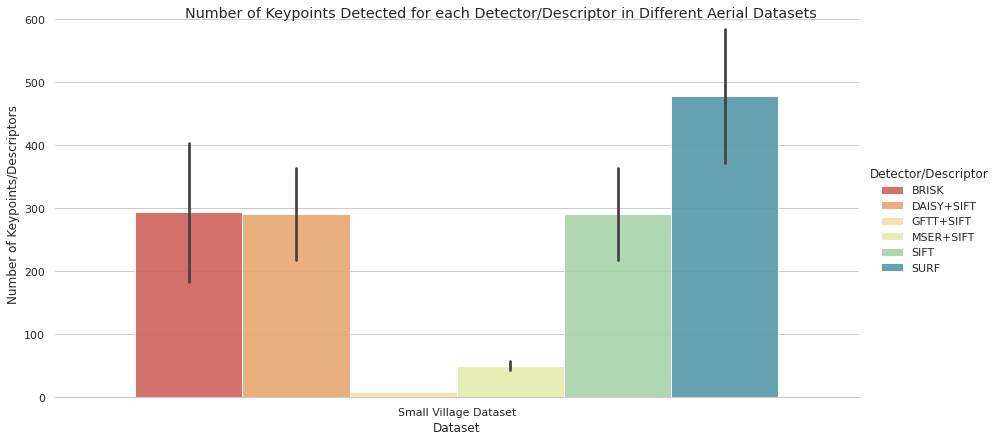

In [111]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_6, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [112]:
g.savefig(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.png')

In [113]:
df_numkey_6.to_csv(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.csv')

Total Number of Matches Detected for each Detector+Descriptor

In [115]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_brisk + num_matches_daisy + num_matches_gftt + num_matches_mser + num_matches_sift + num_matches_surf, 'Detector/Descriptor': ['BRISK']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) +  ['SURF']*(len_files-1) }
df_match_6 = pd.DataFrame(data=d)
df_match_6['Number of Total Matches'] = df_match_6['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

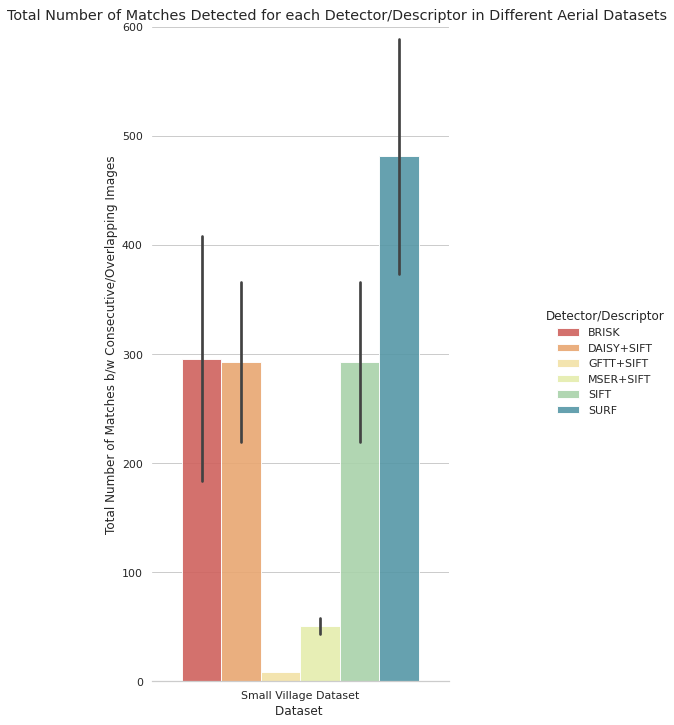

In [116]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [117]:
g.savefig(f'drive/MyDrive/Num_Matches_6_{Dataset}.png')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [118]:
df_match_6['Number of Good Matches'] = num_good_matches_brisk + num_good_matches_daisy + num_good_matches_gftt + num_good_matches_mser + num_good_matches_sift + num_good_matches_surf
df_match_6['Number of Good Matches'] = df_match_6['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

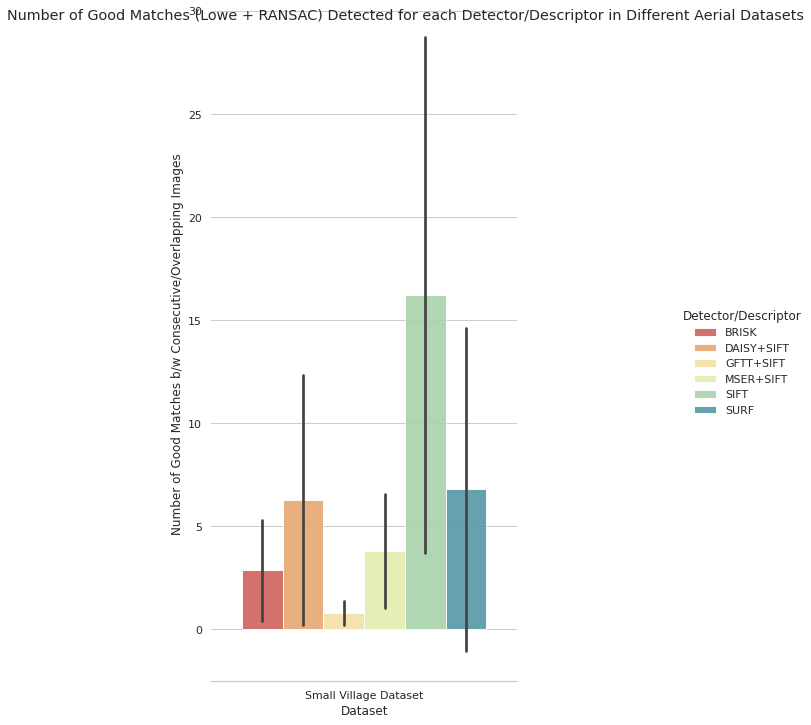

In [119]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [120]:
g.savefig(f'drive/MyDrive/Num_Good_Matches_6_{Dataset}.png')

Recall Rate for each Detector+Descriptor

In [121]:
df_match_6['Recall Rate of Matches'] = df_match_6['Number of Good Matches']/df_match_6['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

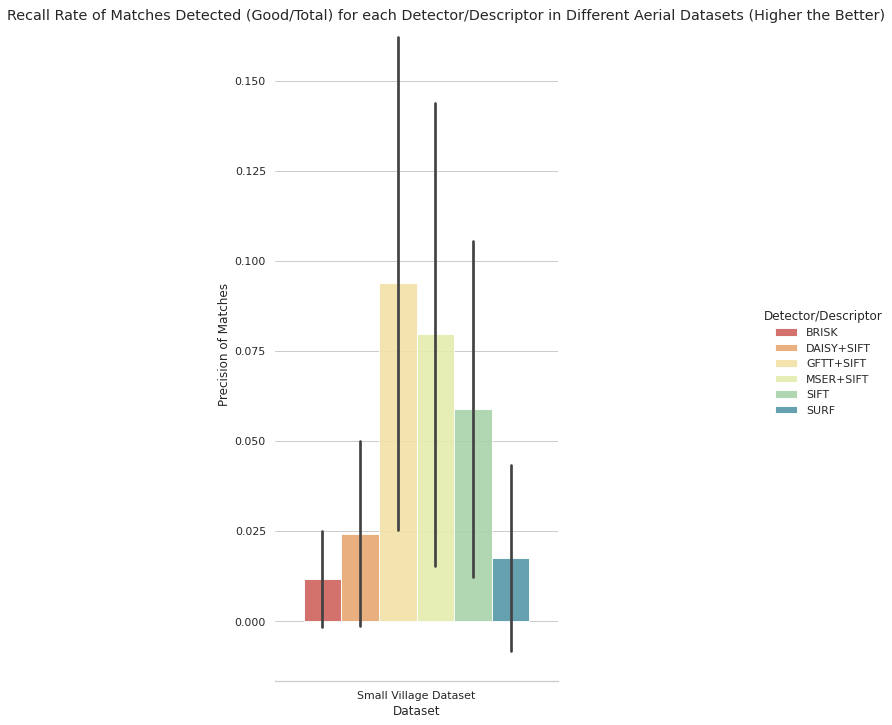

In [123]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [124]:
g.savefig(f'drive/MyDrive/Recall_Rate_Matches_6_{Dataset}.png')

1-Precision Rate for each Detector+Descriptor

In [125]:
df_match_6['1 - Precision Rate of Matches'] = (df_match_6['Number of Total Matches'] - df_match_6['Number of Good Matches'])/df_match_6['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

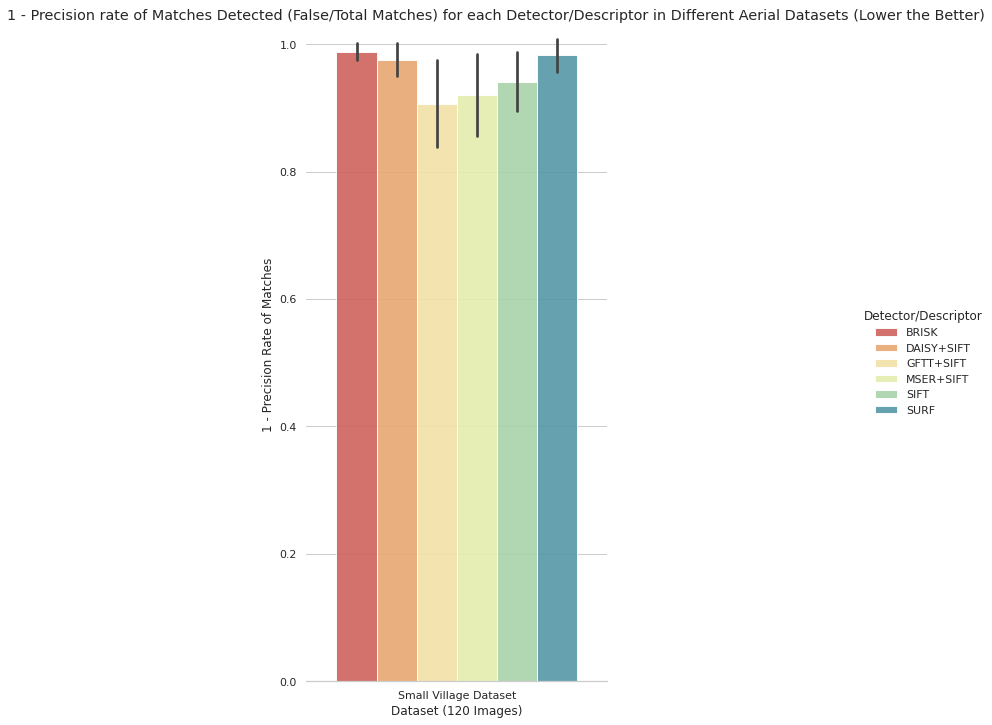

In [126]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [127]:
g.savefig(f'drive/MyDrive/One_minus_Precision_Rate_Matches_6_{Dataset}.png')

F-Score for each Detector+Descriptor

In [128]:
df_match_6['F-Score'] = (2* (1 - df_match_6['1 - Precision Rate of Matches']) * df_match_6['Recall Rate of Matches'])/((1 - df_match_6['1 - Precision Rate of Matches']) + df_match_6['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

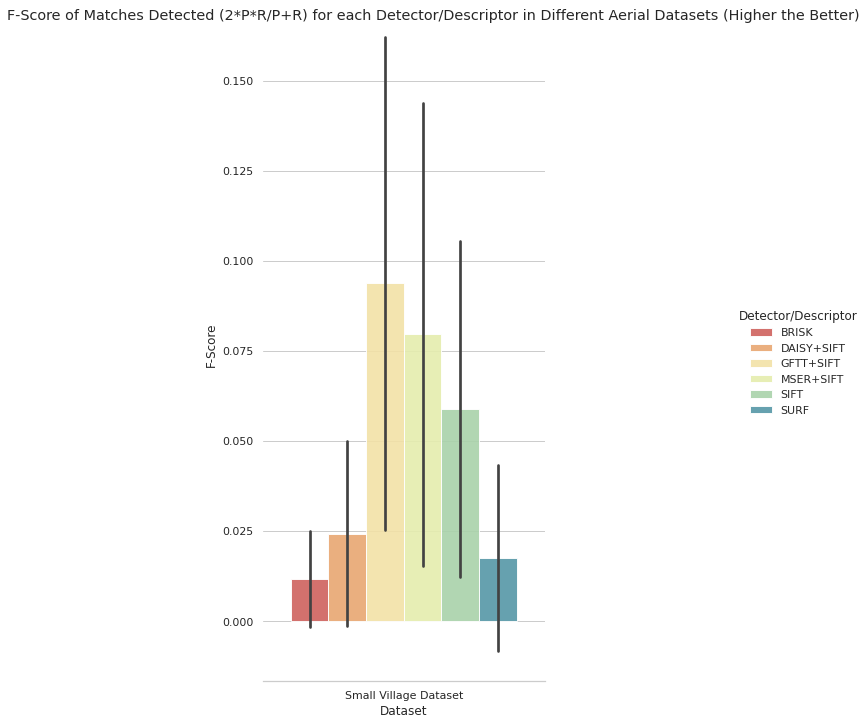

In [129]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [130]:
g.savefig(f'drive/MyDrive/F_Score_Rate_Matches_6_{Dataset}.png')

In [131]:
df_match_6.to_csv(f'drive/MyDrive/All_metrics_6_{Dataset}.csv')

Time for each Detector+Descriptor

In [132]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[2]] + [time_all[1]]+ [time_all[4]] , 'Detector/Descriptor': ['BRISK']*(1) + ['DAISY+SIFT']*(1) +  ['GFTT+SIFT']*(1) + ['MSER+SIFT']*(1) +['SIFT']*(1) + ['SURF']*(1)} 
df_time_6 = pd.DataFrame(data=d)

Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

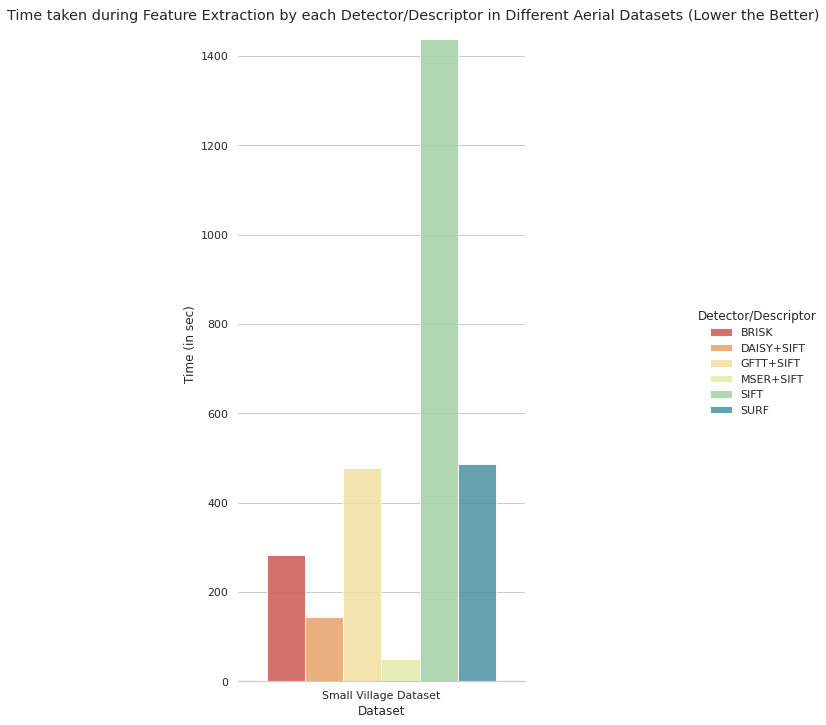

In [133]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_6, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [134]:
g.savefig(f'drive/MyDrive/Time_6_{Dataset}.png')

In [135]:
df_time_6.to_csv(f'drive/MyDrive/Time_6_{Dataset}.csv')